In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.signal import lfilter
from scipy import signal
import scipy
import math
from iir_biquad import iir_biquad as iir_biquad_patrick
from iir_biquad import test as test_patrick
from IIRSim import *
from IIRSimUtils import *
from FrequencyResponse import *
from FPGATestIO import *
from scipy.special import eval_chebyu

# Simulation Comparisons

## Biquad Coefficients

### One Time Calculation

In [ ]:
ADDED_PRECISION=0

b, a = signal.iirnotch(350, 2, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

print("a=%s"%a)
print("b=%s"%b)

# Get the coefficients for the quantized biquad
coeffs = iir_biquad_coeffs(pmag, pangle)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed = np.zeros(len(b))
a_fixed_point_signed = np.zeros(len(a))

coeffs_fixed_point_extended = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed_extended = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed_extended = np.zeros(len(b))
a_fixed_point_signed_extended = np.zeros(len(a))

## Usual Fixed Point
# For transfer function numerator
for i in range(len(b)):
    b_fixed_point_signed[i] = np.floor(b[i] * (2**14))
b_fixed_point_signed = np.array(b_fixed_point_signed, dtype=np.int64)
# Just in case we want to compare these later
# For transfer function denominator, after look-ahead
for i in range(len(a)):
    a_fixed_point_signed[i] = np.floor(a[i] * (2**14))
a_fixed_point_signed = np.array(a_fixed_point_signed, dtype=np.int64)
#  For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed[i] = np.floor(coeffs[i] * (2**14))

coeffs_fixed_point_signed = np.array(coeffs_fixed_point_signed, dtype=np.int64)

## Extended Fixed Point
# For transfer function numerator
for i in range(len(b)):
    b_fixed_point_signed_extended[i] = np.floor(b[i] * (2**(14+ADDED_PRECISION)))
# Just in case we want to compare these later
# For transfer function denominator, after look-ahead
for i in range(len(a)):
    a_fixed_point_signed_extended[i] = np.floor(a[i] * (2**(14+ADDED_PRECISION)))
#  For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed_extended[i] = np.floor(coeffs[i] * (2**(14+ADDED_PRECISION)))

print("a_fixed=%s"%a_fixed_point_signed )
print("b_fixed=%s"%b_fixed_point_signed )

plot_filter_polezero(zmag, zangle, pmag, pangle)

### Biquad Coefficient Write-outs

In [2]:
WRITE_OUT_NEW_COEFFS = True
#notch_freq = 395
# Q_FACTOR = 5
if(WRITE_OUT_NEW_COEFFS):
    for Q_FACTOR in range(1,9,1):
        print("Q:%s"%Q_FACTOR)
        for notch_freq in range(50,1500,5):
            ADDED_PRECISION=0
            write_coeffs(notch_freq, Q_FACTOR, added_precision=0, file_prefix="003_files/coefficients/coeff_file")
            

Q:1
Q:2
Q:3
Q:4
Q:5
Q:6
Q:7
Q:8


## Individual Responses

### Impulse Response

In [3]:
pulse_from_file = import_data("001_files/inputs/pulse_input_height_1024_clipped.dat")

In [4]:
notch_freq = 350
Q_FACTOR = 3
b, a = signal.iirnotch(notch_freq,Q_FACTOR, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

In [5]:
coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(notch_freq,Q_FACTOR))

In [13]:
DEBUG=0
pulse_from_file_FIR = lfilter(b,[1],pulse_from_file.copy())
lfilter_data_zero_first = lfilter([1],a,np.array(pulse_from_file_FIR))#lfilter(b,a,np.array(pulse_from_file))



pulse_from_file_IIR = lfilter([1],a,pulse_from_file.copy())
lfilter_data_pole_first = lfilter(b,[1],np.array(pulse_from_file_IIR))#lfilter(b,a,np.array(pulse_from_file))

lfilter_data = lfilter(b,a,pulse_from_file.copy())#lfilter(b,a,np.array(pulse_from_file))

patrick_data = lfilter(b,[1],test_patrick(pulse_from_file.copy(), 8, pmag, pangle).copy())
patrick_data_reversed = test_patrick(lfilter(b,[1],pulse_from_file.copy()).copy(), 8, pmag, pangle)

patrick_IIR = patrick_biquad(pulse_from_file.copy(), 8, pmag, pangle, debug=DEBUG)

# patrick_data = patrick_biquad(pulse_from_file_FIR, 8, pmag, pangle, ics = None, debug=1)

# patrick_data_reverse = patrick_biquad(pulse_from_file, 8, pmag, pangle, ics = None, debug=1)
# patrick_data_reverse = lfilter(b,[1],patrick_data_reverse)


print("\n****\n")
# The "a"s are now being quantized
python_data_IIR = iir_biquad_run_fixed_point(pulse_from_file.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2]) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)
print("\n****\n")
# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR_extended = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed_extended, [1], pulse_from_file)),dtype=np.int64),
#                                           14+ADDED_PRECISION)
# The "a"s being used are not quantized, they are processed as floating point
# python_data_extended = iir_biquad_run_fixed_point_extended(pulse_from_file.copy(), coeffs_fixed_point_signed_extended, 
#                                                              decimate=True, a1=a[1], a2=a[0],debug=DEBUG, added_precision=ADDED_PRECISION) 
# python_data_extended = lfilter(b,[1],python_data_extended.copy())

# print("\n****\n")
# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], pulse_from_file)),dtype=np.int64),14)
# # The "a"s being used are not quantized, they are processed as floating point
# python_data = iir_biquad_run_fixed_point(np.array(values_with_FIR), coeffs_fixed_point_signed, 
#                                          decimate=True, a1=a[1], a2=a[0],debug=1) 

# print("\n****\n")
# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR_extended = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed_extended, [1], pulse_from_file)),dtype=np.int64),
#                                           14+ADDED_PRECISION)
# # The "a"s being used are not quantized, they are processed as floating point
# python_data_extended = iir_biquad_run_fixed_point_extended(np.array(values_with_FIR_extended), coeffs_fixed_point_signed_extended, 
#                                                              decimate=True, a1=a[1], a2=a[0],debug=1, added_precision=ADDED_PRECISION) 

# plt.plot(range(len(pulse_from_file)), lfilter_data_reversed, label="lfilter Pole First", linestyle="--")
plt.plot(range(len(pulse_from_file)), lfilter_data, label="lfilter", linestyle="-")

# plt.plot(range(len(pulse_from_file)), patrick_data, label="Floating Point Pole First", marker="o", linestyle="None")
# plt.plot(range(len(pulse_from_file)), patrick_data_reversed, label="Floating Point Zero First", marker="x", linestyle="None")

# plt.plot(range(len(pulse_from_file)), patrick_data_combined, label="Patrick Sim Combined", marker="x")
# plt.plot(range(len(pulse_from_file)), lfilter_data_reversed, label="lfilter Pole First", linestyle=":")
# plt.plot(range(len(pulse_from_file)), python_data, label="python sim", linestyle="None", marker="o")
plt.plot(range(len(pulse_from_file)), python_data, label="python sim", linestyle="None", marker=".")
plt.legend()
plt.title("Impulse Responses Total")
plt.xlabel("Counts")
plt.ylabel("ADC")
plt.xlim(30,70)
plt.ylim(-1000,1000)
plt.savefig("PoleZeroOrder.png")
plt.show()


plt.plot(range(len(pulse_from_file)), pulse_from_file_IIR, label="lfilter", linestyle="-")

plt.plot(range(len(pulse_from_file)), patrick_IIR, label="Floating Point Pole First", marker="o", linestyle="None")
# plt.plot(range(len(pulse_from_file)), patrick_data_reversed, label="Floating Point Zero First", marker="x", linestyle="None")

# plt.plot(range(len(pulse_from_file)), patrick_data_combined, label="Patrick Sim Combined", marker="x")
# plt.plot(range(len(pulse_from_file)), lfilter_data_reversed, label="lfilter Pole First", linestyle=":")
# plt.plot(range(len(pulse_from_file)), python_data, label="python sim", linestyle="None", marker="o")
plt.plot(range(len(pulse_from_file)), python_data_IIR, label="python sim", linestyle="None", marker=".")
plt.legend()
plt.title("Impulse Responses Pole Only")
plt.xlim(30,70)
plt.ylim(-1200,1500)
plt.show()
print(lfilter_data[32])
print(python_data[32])

# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,lfilter_data ), label="simulation difference")
# plt.title("Patrick Tone Response Difference")
# plt.show()

# plt.plot(range(len(pulse_from_file)), np.subtract(python_data,lfilter_data ), label="python simulation difference")
# plt.title("Python Tone Response Difference")
# plt.legend()
# plt.xlim(0,500)
# plt.title("Impulse Responses")
# plt.show()

# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,lfilter_data ), label="patrick simulation difference")
# plt.title("Impulse Response Difference")
# plt.xlim(0,500)
# plt.show()


# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,python_data ), label="both simulation difference")
# plt.title("Impulse Response Difference")
# plt.xlim(0,500)
# plt.show()

plt.plot(range(len(pulse_from_file)), lfilter_data_pole_first, label="lfilter Pole First", marker="o")
plt.plot(range(len(pulse_from_file)), lfilter_data_zero_first, label="lfilter Zero First", marker="x")
plt.plot(range(len(pulse_from_file)), lfilter_data, label="lfilter combined")

plt.legend()
plt.title("Impulse Responses lfilter")
plt.xlim(30,70)
# plt.ylim(-1000,1000)
plt.show()


TypeError: test() takes 0 positional arguments but 4 were given

### Tone Response

In [ ]:
tone_from_file = import_data("001_files/inputs/input_200_MHz_4_zpclocks_hanning.dat")

In [ ]:
notch_freq = 350
Q_FACTOR = 3
b, a = signal.iirnotch(notch_freq,Q_FACTOR, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

In [ ]:
coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(notch_freq,Q_FACTOR))

In [ ]:
# patrick_data = lfilter(b,[1],patrick_biquad(tone_from_file, 8, pmag, pangle, ics = None))
# lfilter_data = lfilter(b,a,np.array(tone_from_file))

DEBUG=False

lfilter_data = lfilter(b,a,tone_from_file.copy())#lfilter(b,a,np.array(pulse_from_file))

# The "a"s being used are not quantized, they are processed as floating point

patrick_data = lfilter(b,[1],patrick_biquad(tone_from_file.copy(), 8, pmag, pangle, ics = None, debug=DEBUG).copy())

python_data_IIR = iir_biquad_run_fixed_point(tone_from_file.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], tone_from_file)),dtype=np.int64),14)

# # The "a"s being used are not quantized, they are processed as floating point
# python_data = iir_biquad_run_fixed_point(np.array(values_with_FIR), coeffs_fixed_point_signed, 
#                                          decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) 

# plt.plot(range(len(tone_from_file)), patrick_data, label="Patrick Sim")
plt.plot(range(len(tone_from_file)), lfilter_data, label="lfilter", linestyle="-")
plt.plot(range(len(tone_from_file)), python_data, label="python sim", linestyle=":")
plt.plot(range(len(tone_from_file)), patrick_data, label="floating point sim", linestyle="--")
plt.legend()
plt.title("Tone Responses")
# plt.xlim(40000,40100)
plt.show()

plt.plot(range(len(tone_from_file)), lfilter_data, label="lfilter", linestyle="None", marker="o")
plt.plot(range(len(tone_from_file)), python_data, label="python sim", linestyle="None", marker=".")
plt.plot(range(len(tone_from_file)), patrick_data, label="floating sim", linestyle="None", marker="+")
plt.legend()
plt.title("Tone Responses")
# plt.xlim(40050,40100)
plt.xlim(1160,1180)
plt.ylim(-10,10)
plt.show()

# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,lfilter_data ), label="simulation difference")
# plt.title("Patrick Tone Response Difference")
# plt.show()

plt.plot(range(len(tone_from_file)), np.subtract(python_data,lfilter_data ), label="simulation difference", marker="o")
plt.title("Python Tone Response Difference")
plt.xlim(40050,40100)
plt.show()

### Gaussian Noise Response

In [ ]:
gauss_from_file = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_0.dat")

In [ ]:
notch_freq = 350
Q_FACTOR = 3
b, a = signal.iirnotch(notch_freq,Q_FACTOR, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

In [ ]:
coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(notch_freq,Q_FACTOR))

In [ ]:
# patrick_data = lfilter(b,[1],patrick_biquad(gauss_from_file, 8, pmag, pangle, ics = None))
# lfilter_data = lfilter(b,a,np.array(gauss_from_file))

lfilter_data = lfilter(b,a,gauss_from_file.copy())#lfilter(b,a,np.array(pulse_from_file))

# The "a"s being used are not quantized, they are processed as floating point

patrick_data = lfilter(b,[1],iir_biquad(gauss_from_file.copy(), 8, pmag, pangle, ics = None, debug=DEBUG).copy())

python_data_IIR = iir_biquad_run_fixed_point(gauss_from_file.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], gauss_from_file)),dtype=np.int64),14)

# # The "a"s being used are not quantized, they are processed as floating point
# python_data = iir_biquad_run_fixed_point(np.array(values_with_FIR), coeffs_fixed_point_signed, 
#                                          decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) 

# plt.plot(range(len(gauss_from_file)), patrick_data, label="Patrick Sim")
plt.plot(range(len(gauss_from_file)), lfilter_data, label="lfilter", linestyle="-")
plt.plot(range(len(gauss_from_file)), python_data, label="python sim", linestyle=":")
plt.plot(range(len(gauss_from_file)), patrick_data, label="floating point sim", linestyle="--")
plt.legend()
plt.title("Gauss Responses")
# plt.xlim(40000,40100)
plt.show()

plt.plot(range(len(gauss_from_file)), lfilter_data, label="lfilter", linestyle="None", marker="o")
plt.plot(range(len(gauss_from_file)), python_data, label="python sim", linestyle="None", marker=".")
plt.plot(range(len(gauss_from_file)), patrick_data, label="floating sim", linestyle="None", marker="+")
plt.legend()
plt.title("Gaussian Responses")
plt.xlim(40050,40100)
plt.show()

# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,lfilter_data ), label="simulation difference")
# plt.title("Patrick gauss Response Difference")
# plt.show()

plt.plot(range(len(gauss_from_file)), np.subtract(python_data,lfilter_data), label="simulation difference", marker="o")
plt.title("Gaussian Response Difference")
plt.xlim(40050,40100)
plt.show()

### Testing Hugo's Parameters

In [ ]:
# These are the values taken from the plot in Hugo's email
A_hugo = 0.912
B_hugo = -1.041
pole_hugo = 0.908
theta_hugo = 0.960 # this is in radians

b_hugo = [A_hugo,B_hugo,A_hugo]#, a = signal.iirnotch(notch_freq,Q_FACTOR, 3000)
tf = signal.zpk2tf([],[pole_hugo * np.exp(1j*theta_hugo), pole_hugo * np.exp(-1j*theta_hugo)], 1)
a_hugo = tf[1]

In [ ]:
# Prove to myself I am doing this right
print(tf)
a_hugo = tf[1]
print(np.angle(signal.tf2zpk(tf[0], tf[1])[1][0]))
print(a_hugo)

In [ ]:
print(np.angle(signal.tf2zpk(b_hugo,[1])[0][0]))
print(np.abs(signal.tf2zpk(b_hugo,[1])[0][0]))

In [ ]:

# Get the coefficients for the quantized biquad
coeffs = iir_biquad_coeffs(pole_hugo, theta_hugo)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed = np.zeros(len(b_hugo))
a_fixed_point_signed = np.zeros(len(a_hugo))

coeffs_fixed_point_extended = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed_extended = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed_extended = np.zeros(len(b_hugo))
a_fixed_point_signed_extended = np.zeros(len(a_hugo))

## Usual Fixed Point
# For transfer function numerator
for i in range(len(b_hugo)):
    b_fixed_point_signed[i] = np.floor(b_hugo[i] * (2**14))
b_fixed_point_signed = np.array(b_fixed_point_signed, dtype=np.int64)
# Just in case we want to compare these later
# For transfer function denominator, after look-ahead
for i in range(len(a_hugo)):
    a_fixed_point_signed[i] = np.floor(a_hugo[i] * (2**14))
a_fixed_point_signed = np.array(a_fixed_point_signed, dtype=np.int64)
#  For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed[i] = np.floor(coeffs[i] * (2**14))

coeffs_fixed_point_signed = np.array(coeffs_fixed_point_signed, dtype=np.int64)

In [ ]:
DEBUG = 0
gauss_from_file = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_0.dat")
lfilter_data = lfilter(b_hugo,a_hugo,gauss_from_file.copy())#lfilter(b,a,np.array(pulse_from_file))

# The "a"s being used are not quantized, they are processed as floating point

patrick_data = lfilter(b_hugo,[1],iir_biquad_patrick(gauss_from_file.copy(), 8, pole_hugo, theta_hugo, ics = None, debug=DEBUG).copy())

python_data_IIR = iir_biquad_run_fixed_point(gauss_from_file.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], gauss_from_file)),dtype=np.int64),14)

# # The "a"s being used are not quantized, they are processed as floating point
# python_data = iir_biquad_run_fixed_point(np.array(values_with_FIR), coeffs_fixed_point_signed, 
#                                          decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) 

# plt.plot(range(len(gauss_from_file)), patrick_data, label="Patrick Sim")
plt.plot(range(len(gauss_from_file)), lfilter_data, label="lfilter", linestyle="-")
plt.plot(range(len(gauss_from_file)), python_data, label="python sim", linestyle=":")
plt.plot(range(len(gauss_from_file)), patrick_data, label="floating point sim", linestyle="--")
plt.legend()
plt.title("Gauss Responses")
# plt.xlim(40000,40100)
plt.show()

plt.plot(range(len(gauss_from_file)), lfilter_data, label="lfilter", linestyle="None", marker="o")
plt.plot(range(len(gauss_from_file)), python_data, label="python sim", linestyle="None", marker=".")
plt.plot(range(len(gauss_from_file)), patrick_data, label="floating sim", linestyle="None", marker="+")
plt.legend()
plt.title("Gaussian Responses")
plt.xlim(40050,40100)
plt.show()

# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,lfilter_data ), label="simulation difference")
# plt.title("Patrick gauss Response Difference")
# plt.show()

plt.plot(range(len(gauss_from_file)), np.subtract(python_data,lfilter_data), label="simulation difference", marker="o")
plt.title("Gaussian Response Difference")
plt.xlim(40050,40100)
plt.show()

## Frequency Response Using Gaussians

### Not using functions

In [ ]:
fft_input_result = {}
fft_patrick_result = {}
fft_lfilter_result = {}
fft_python_result = {}

In [ ]:
TRIALS = 100
NOTCH = 300
Q_FACTOR = 30
DEBUG=0

b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

# Import the Gaussian input data once to get the lengths
data_len = len(import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%0))
fft_input_results = np.zeros((TRIALS, data_len))     
fft_patrick_results = np.zeros((TRIALS, data_len))     
fft_python_results = np.zeros((TRIALS, data_len))   
fft_lfilter_results = np.zeros((TRIALS, data_len))

# Run the trials on the data
for i in range(TRIALS):
    # Import the trial inputs
    gauss_samps = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%i)

    # Run the filters on the trials
    patrick_data = lfilter(b,[1],patrick_biquad(gauss_samps.copy(), 8, pmag, pangle, ics = None))
    lfilter_data = lfilter(b,a,gauss_samps)

    python_data_IIR = iir_biquad_run_fixed_point(gauss_samps.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
    python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

    # # The "a"s being used are not quantized, they are processed as floating point
    # python_data_iir = iir_biquad_run_fixed_point(gauss_samps.copy(), coeffs_fixed_point_signed, 
    #                                          decimate=False, a1=a[1], a2=a[2],debug=0) 

    
    # # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
    # python_data = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], python_data_iir)),dtype=np.int64),14)
    
    fft_input_results[i] = np.abs(np.fft.fft(gauss_samps))**2   
    fft_patrick_results[i] = np.abs(np.fft.fft(patrick_data))**2
    fft_lfilter_results[i] = np.abs(np.fft.fft(lfilter_data))**2
    fft_python_results[i] = np.abs(np.fft.fft(python_data))**2
    if(i%10 == 0):
        print(i)
fft_input_result[NOTCH] = np.mean(fft_input_results, axis=0)
fft_patrick_result[NOTCH] = np.mean(fft_patrick_results, axis=0)
fft_lfilter_result[NOTCH] = np.mean(fft_lfilter_results, axis=0)
fft_python_result[NOTCH] = np.mean(fft_python_results, axis=0)

In [ ]:
fft_lfilter_result.keys()

In [ ]:
plot_notch_freq = 300
plot_sample_freq=3000
plt.plot(plot_sample_freq*np.fft.fftfreq(len(fft_input_result[plot_notch_freq])),np.abs(fft_input_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="input", markersize=5, alpha=0.9, color="C0")
plt.plot(plot_sample_freq*np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(plot_sample_freq*np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq]), linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
plt.plot(plot_sample_freq*np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq]), linestyle="None",
         marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**1)
plt.title("Gaussian noise in filters")
# plt.xlim(0,0.5)
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
if(plot_sample_freq > 1):
    plt.xlabel("Freq (MHz)")
else:
    plt.xlabel("Frequency/(Sampling Frequency)")
plt.show()

mean_power = np.mean(fft_input_result[plot_notch_freq])


# plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq])/mean_power, linestyle="None", 
#          marker=".", label="floating point with CLA", markersize=1, alpha=0.05, color="C1")
plt.plot(plot_sample_freq*np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.5, color="C1")
plt.plot(plot_sample_freq*np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="Fixed Point CLA", markersize=5, alpha=0.5, color="C2")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**-1)
plt.title("Gaussian Noise in Filters")
plt.xlim(plot_sample_freq*0,plot_sample_freq*0.5)
if(plot_sample_freq > 1):
    plt.xlabel("Freq (MHz)")
else:
    plt.xlabel("Frequency/(Sampling Frequency)")
plt.ylabel("Gain")
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()

In [ ]:
N=11

plot_freqs = plot_sample_freq*np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq]))[int(np.floor(N/2.0)):int(-np.floor(N/2.0))]

plot_notch_freq = 300
plt.plot(plot_freqs,np.convolve(np.abs(fft_input_result[plot_notch_freq]), np.ones(N)/N, mode='valid'), linestyle="None", 
         marker=".", label="input", markersize=5, alpha=0.9, color="C0")
plt.plot(plot_freqs,np.convolve(np.abs(fft_patrick_result[plot_notch_freq]), np.ones(N)/N, mode='valid'), linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(plot_freqs,np.convolve(np.abs(fft_lfilter_result[plot_notch_freq]), np.ones(N)/N, mode='valid'), linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
plt.plot(plot_freqs,np.convolve(np.abs(fft_python_result[plot_notch_freq]), np.ones(N)/N, mode='valid'), linestyle="None",
         marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**4)
plt.title("Gaussian Noise in Filters")
# plt.xlim(0,0.5)
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
if(plot_sample_freq > 1):
    plt.xlabel("Freq (MHz)")
else:
    plt.xlabel("Frequency/(Sampling Frequency)")
plt.show()

mean_power = np.mean(fft_input_result[plot_notch_freq])


plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq])/mean_power, linestyle="None", 
         marker=".", label="floating point with CLA", markersize=1, alpha=0.05, color="C1")
plt.plot(plot_freqs,np.convolve(np.abs(fft_patrick_result[plot_notch_freq]), np.ones(N)/N, mode='valid')/mean_power, linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C2")
# plt.plot(plot_freqs,np.convolve(np.abs(fft_lfilter_result[plot_notch_freq]), np.ones(N)/N, mode='valid')/mean_power, linestyle="None",
         # marker=".", label="lfilter", markersize=5, alpha=0.5, color="C2")
plt.plot(plot_freqs,np.convolve(np.abs(fft_python_result[plot_notch_freq]), np.ones(N)/N, mode='valid')/mean_power, linestyle="None",
         marker=".", label="Fixed Point CLA", markersize=5, alpha=0.5, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**-3)
plt.title("Gaussian Noise in Filters")
plt.xlim(plot_sample_freq*0,plot_sample_freq*0.5)
if(plot_sample_freq > 1):
    plt.xlabel("Freq (MHz)")
else:
    plt.xlabel("Frequency/(Sampling Frequency)")
plt.ylabel("Gain")
plt.savefig("GaussianNotch_%sMHz.png"%plot_notch_freq)
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()

plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq])/mean_power, linestyle="None", 
         marker=".", label="floating point with CLA", markersize=1, color="C1")
plt.plot(plot_freqs,np.convolve(np.abs(fft_patrick_result[plot_notch_freq]), np.ones(N)/N, mode='valid')/mean_power, linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C2")
# plt.plot(plot_freqs,np.convolve(np.abs(fft_lfilter_result[plot_notch_freq]), np.ones(N)/N, mode='valid')/mean_power, linestyle="None",
         # marker=".", label="lfilter", markersize=5, alpha=0.5, color="C2")
plt.plot(plot_freqs,np.convolve(np.abs(fft_python_result[plot_notch_freq]), np.ones(N)/N, mode='valid')/mean_power, linestyle="None",
         marker=".", label="Fixed Point CLA", markersize=5, alpha=1, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**-3)
plt.title("Gaussian Noise in Filters")
plt.xlim(240,380)
if(plot_sample_freq > 1):
    plt.xlabel("Freq (MHz)")
else:
    plt.xlabel("Frequency/(Sampling Frequency)")
plt.ylabel("Gain")
plt.savefig("GaussianNotchZoom_%sMHz.png"%plot_notch_freq)
plt.show()

### Functional Gaussian Probed Frequency Response

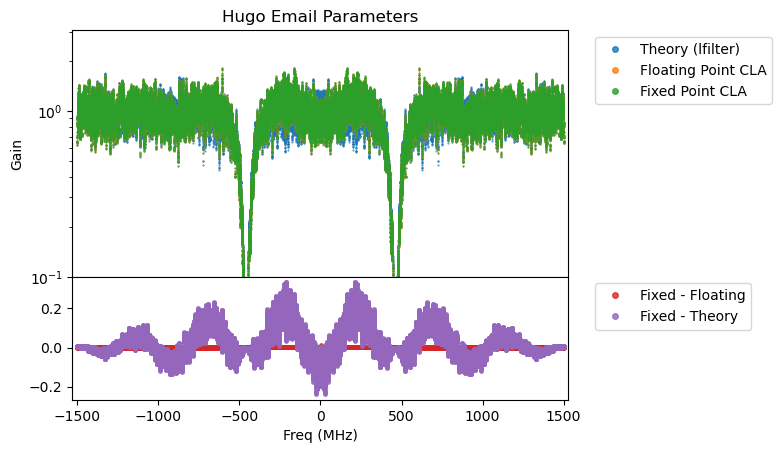

<Figure size 640x480 with 0 Axes>

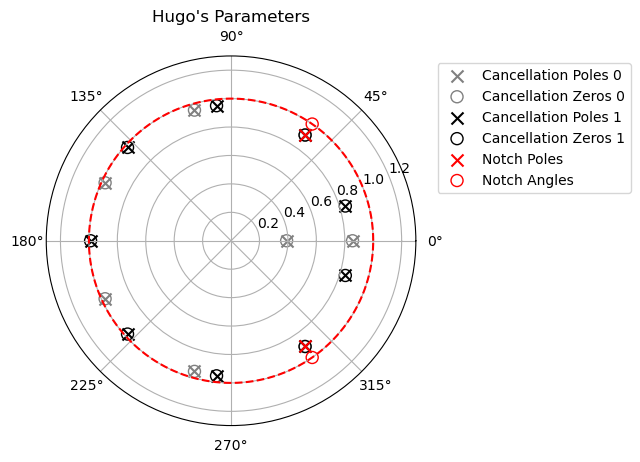

In [11]:
# These are the values taken from the plot in Hugo's email
A_hugo = 0.912
B_hugo = -1.041
pole_hugo = 0.908
theta_hugo = 0.960 # this is in radians

b_hugo = [A_hugo,B_hugo,A_hugo]#, a = signal.iirnotch(notch_freq,Q_FACTOR, 3000)
tf = signal.zpk2tf([],[pole_hugo * np.exp(1j*theta_hugo), pole_hugo * np.exp(-1j*theta_hugo)], 1)
a_hugo = tf[1]

gaussian_probe_frequency_response_manual(trials=2, A=A_hugo, B=B_hugo, pmag=pole_hugo, pangle=theta_hugo, smooth=35, savename="001_files/images/filter_diff_HUGO_EXAMPLE", label_cancellations=False)

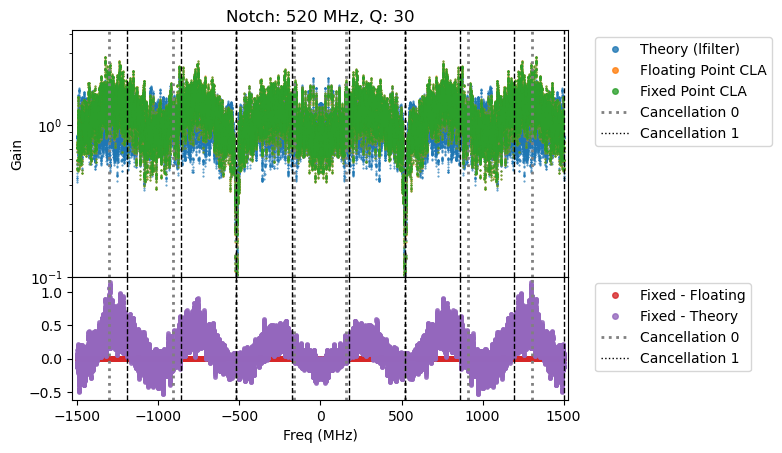

<Figure size 640x480 with 0 Axes>

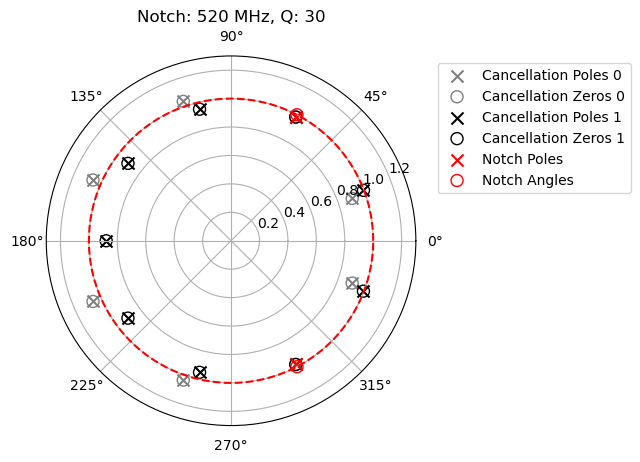

In [14]:
for notch_f in [520]:#range(100,1500,200):
    gaussian_probe_frequency_response(trials=1, notch=notch_f, q_factor=30, smooth=35, savename="001_files/images/filter_diff_%sMHz"%notch_f)

In [ ]:
for notch_f in [800]:#range(100,1500,200):
    for q_f in [5]:#range(1,9,2):
        gaussian_probe_frequency_response(trials=20, notch=notch_f, q_factor=q_f, smooth=35, savename="001_files/images/filter_diff_Q%s_%sMHz_cancellations"%(q_f,notch_f), label_cancellations=True)

### Extended Precision, rounding coeffs

In [ ]:
fft_input_result = {}
fft_patrick_result = {}
fft_lfilter_result = {}
fft_python_result = {}

fft_python_extended_result = {}

In [ ]:
TRIALS = 70
NOTCH = 800
Q = 30
plot_sample_freq=3000
ADDED_PRECISION=-10

# Get the parameters of the notch
b, a = signal.iirnotch(NOTCH, Q, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

# Get the coefficients for the quantized biquad
coeffs = iir_biquad_coeffs(pmag, pangle)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed = np.zeros(len(b), dtype=np.int64)

# For transfer function numerator
for i in range(len(b)):
    b_fixed_point_signed[i] = np.floor(b[i] * (2**(14+ADDED_PRECISION)))
# Just in case we want to compare these later
a_fixed_point_signed = np.zeros(len(a),dtype=np.int64)
# For transfer function denominator, after look-ahead
for i in range(len(a)):
    a_fixed_point_signed[i] = np.floor(a[i] * (2**(14+ADDED_PRECISION)))
#  For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed[i] = np.array(np.floor(coeffs[i] * (2**(14+ADDED_PRECISION))),dtype=np.int64)

# Import the Gaussian input data once to get the lengths
data_len = len(import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%0))
fft_input_results = np.zeros((TRIALS, data_len))     
fft_patrick_results = np.zeros((TRIALS, data_len))     
fft_python_results = np.zeros((TRIALS, data_len))   
fft_lfilter_results = np.zeros((TRIALS, data_len))

# Run the trials on the data
for i in range(TRIALS):
    # Import the trial inputs
    gauss_samps = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%i)

    # Run the filters on the trials
    patrick_data = lfilter(b,[1],patrick_biquad(gauss_samps, 8, pmag, pangle, ics = None))
    lfilter_data = lfilter(b,a,gauss_samps)

    # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
    # values_with_FIR = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], gauss_samps)),dtype=np.int64),(14+ADDED_PRECISION))

    # The "a"s being used are not quantized, they are processed as floating point
    # print(type(a_fixed_point_signed[1]))
    python_data_IIR = iir_biquad_run_fixed_point_extended(gauss_samps, coeffs_fixed_point_signed, 
                                             decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0,added_precision=ADDED_PRECISION) 

    python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),(14+ADDED_PRECISION))
    
    fft_input_results[i] = np.abs(np.fft.fft(gauss_samps))**2   
    fft_patrick_results[i] = np.abs(np.fft.fft(patrick_data))**2
    fft_lfilter_results[i] = np.abs(np.fft.fft(lfilter_data))**2
    fft_python_results[i] = np.abs(np.fft.fft(python_data))**2
    if(i%10 == 0):
        print(i)
fft_input_result[NOTCH] = np.mean(fft_input_results, axis=0)
fft_patrick_result[NOTCH] = np.mean(fft_patrick_results, axis=0)
fft_lfilter_result[NOTCH] = np.mean(fft_lfilter_results, axis=0)
fft_python_result[NOTCH] = np.mean(fft_python_results, axis=0)

In [ ]:
plot_notch_freq = NOTCH
plt.plot(np.fft.fftfreq(len(fft_input_result[plot_notch_freq])),np.abs(fft_input_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="input", markersize=5, alpha=0.9, color="C0")
plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq]), linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
plt.plot(np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq]), linestyle="None",
         marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**8)
plt.title("Gaussian noise in filters")
# plt.xlim(0,0.5)
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()

mean_power = np.mean(fft_input_result[plot_notch_freq])



plt.plot(plot_sample_freq*np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.5, color="C1")
plt.plot(plot_sample_freq*np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="python", markersize=8, alpha=0.8, color="C2")
plt.plot(plot_sample_freq*np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq])/mean_power, linestyle="None", 
         marker=".", label="floating point with CLA", markersize=3, alpha=0.8, color="C0")
# plt.legend()
# plt.yscale("log")
# plt.gca().set_ylim(bottom=10**-5)
# plt.title("Gaussian noise in filters")
# plt.xlim(0,0.5)
# plt.xlabel("Frequency/(Sampling Frequency)")
# plt.ylabel("Gain")
# # plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
# plt.show()

plt.yscale("log")
plt.gca().set_ylim(bottom=10**-1)
plt.title("Notch: %s MHz, Q: %s, Added Precision: %s bits"%(NOTCH, Q, ADDED_PRECISION))
plt.xlim(plot_sample_freq*0,plot_sample_freq*0.5)
if(plot_sample_freq > 1):
    plt.xlabel("Freq (MHz)")
else:
    plt.xlabel("Frequency/(Sampling Frequency)")
plt.ylabel("Gain")
plt.legend()
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()

## Verilog Testing

### FFT Analysis

### With Zero

In [ ]:
TRIALS = 1
NOTCH = 800
Q_FACTOR = 8



verilog_nominal_latency = 136
verilog_data_decimated = {}
verilog_data_decimated[Q_FACTOR] = {}
verilog_data_decimated[Q_FACTOR][NOTCH] = []
for trial in range(TRIALS):
    with open("001_files/outputs/verilog/output_trial_%s_notch_%s_MHz_%s.txt"%(trial, NOTCH, Q_FACTOR), "r") as in_file:
        data = []
        for line in in_file:
            data.append(convert_from_fixed_point(int(int(line)), 12, 0))
            #L NEED TO FIND LATENCY, AND THEN APPLY FILTER NORMALLY FOR SAMPLES 2-7
        print(len(data))
        verilog_data_decimated[Q_FACTOR][NOTCH].append(np.array(data[verilog_nominal_latency:],dtype=np.int64))

gauss_samps = []
gauss_original_samps = []
for trial in range(TRIALS):
    gauss_run = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%i)
    gauss_original_samps.append(gauss_run)
    gauss_samps.append(gauss_run[:-verilog_nominal_latency])
    print(len(import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%i)))
    # with open("001_files/outputs/verilog/output_trial_%s_notch_%s_MHz_%s.txt"%(trial, NOTCH, Q_FACTOR), "r") as in_file:
    #     data = []
    #     for line in in_file:
    #         data.append(convert_from_fixed_point(int(int(line)), 12, 0))
    #         #L NEED TO FIND LATENCY, AND THEN APPLY FILTER NORMALLY FOR SAMPLES 2-7
    #     verilog_data_decimated[Q_FACTOR][NOTCH] = np.array(data[verilog_nominal_latency:],dtype=np.int64)

coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

python_datas = []
for trial in range(TRIALS):
    python_data_IIR = iir_biquad_run_fixed_point(gauss_original_samps[trial].copy(), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
    python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)
    python_datas.append(python_data[:-verilog_nominal_latency])


In [ ]:
print(len(gauss_samps[0]))
print(len(verilog_data_decimated[Q_FACTOR][NOTCH][0]))
clocks = range(len(gauss_samps[0]))
plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0]-0.5, label="V")
plt.plot(clocks, gauss_samps[0], label="In")
plt.plot(clocks, python_datas[0]-0.25, label="Py")
# plt.xlim(79000+300,79000+1000)
plt.xlim(550,800)
plt.ylim(-5,5)
plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
plt.show()

In [ ]:
TRIALS = 1
NOTCH = 800
Q_FACTOR = 8
verilog_nominal_latency = 144

b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)

verilog_data = []
with open("001_files/outputs/verilog/pulse_output_height_512.dat", "r") as in_file:
    data = []
    for line in in_file:
        data.append(convert_from_fixed_point(int(int(line)), 12, 0))
        #L NEED TO FIND LATENCY, AND THEN APPLY FILTER NORMALLY FOR SAMPLES 2-7
    verilog_data = np.array(data[verilog_nominal_latency:],dtype=np.int64)
print(len(data))
pulse_run = import_data("001_files/inputs/pulse_input_height_512_clipped.dat")
pulse_original_samps = pulse_run.copy()
pulse_samps = pulse_run[:-verilog_nominal_latency].copy()
print(len(pulse_run))

coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

python_data_IIR = iir_biquad_run_fixed_point(pulse_original_samps.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

python_data_FIR =np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],pulse_original_samps.copy())),dtype=np.int64)
python_data_zero_first = np.right_shift(iir_biquad_run_fixed_point(python_data_FIR.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) ,14)

python_data_trimmed = python_data[:-verilog_nominal_latency].copy()
python_data_zero_first_trimmed = python_data_zero_first[:-verilog_nominal_latency].copy()

lfilter_data = lfilter(b,a, pulse_original_samps.copy()) 
lfilter_data_trimmed = lfilter_data[:-verilog_nominal_latency].copy()

In [ ]:
print(len(python_data_trimmed))
print(len(verilog_data))
print("INVESTIGATE IIR ONLY BEHAVIOR")
clocks = range(len(pulse_samps))
plt.plot(clocks, verilog_data, linestyle="None", marker="o", label="V")
plt.plot(clocks, pulse_samps, linestyle="None", marker="x", label="In")
plt.plot(clocks, python_data_trimmed, linestyle="None", marker=".", label="Py")
plt.plot(clocks, python_data_zero_first_trimmed, linestyle="None", marker="+", label="Py Zf")
plt.plot(clocks, lfilter_data_trimmed, linestyle="-", label="Lft")
# plt.xlim(79000+300,79000+1000)
plt.xlim(20,70)
for i in range(40):
    plt.axvline(x=8*i, linestyle=":", color="grey")
    plt.axvline(x=8*i+1, linestyle=":", color="grey")
# plt.ylim(-5,5)
plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
plt.title("Verilog is in wrong zero-pole order")
plt.show()
print(b_fixed_point_signed/(2**14))
print(a_fixed_point_signed/(2**14))

### Just IIR, b=[0,1,0]

In [ ]:
TRIALS = 1
NOTCH = 800
Q_FACTOR = 8
verilog_nominal_latency = 144 + 0 # The +1 is for the latency added by the b=[0,1,0] numerator

b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)

verilog_data = []
with open("001_files/outputs/verilog/no_zero_pulse_output_height_512.dat", "r") as in_file:
    data = []
    for line in in_file:
        data.append(convert_from_fixed_point(int(int(line)), 12, 0))
        #L NEED TO FIND LATENCY, AND THEN APPLY FILTER NORMALLY FOR SAMPLES 2-7
    verilog_data = np.array(data[verilog_nominal_latency:],dtype=np.int64)
print(len(data))
pulse_run = import_data("001_files/inputs/pulse_input_height_512_clipped.dat")
pulse_original_samps = pulse_run.copy()
pulse_samps = pulse_run[:-verilog_nominal_latency].copy()
print(len(pulse_run))

coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

python_data_IIR = iir_biquad_run_fixed_point(pulse_original_samps.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array([0,16384,0], dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

python_data_FIR = np.array(np.floor(lfilter(np.array([0,16384,0], dtype=float),[1],pulse_original_samps.copy())),dtype=np.int64)
python_data_zero_first = np.right_shift(iir_biquad_run_fixed_point(python_data_FIR.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) ,14)

python_data_trimmed = python_data[:-verilog_nominal_latency].copy()
python_data_zero_first_trimmed = python_data_zero_first[:-verilog_nominal_latency].copy()

lfilter_data = lfilter([0,1,0],a, pulse_original_samps.copy()) 
lfilter_data_trimmed = lfilter_data[:-verilog_nominal_latency].copy()

In [ ]:
FIR_OFFSET=1
USE_FIR = False
clipped_length = int(len(verilog_data)/8)*8
incremental_data = verilog_data.copy()[:clipped_length]
IIR_data = verilog_data.copy()[:clipped_length]
# FINISH IIR
# for clock in range(int(len(verilog_data)/8)):
#     for i in range(0,2):
#         idx = clock*8+i
#         if USE_FIR: # This is being applied to existing outputs
#             incremental_data[idx] = np.right_shift((b_fixed_point_signed[0]) * IIR_data[idx],14)
#             incremental_data[idx] += np.right_shift((b_fixed_point_signed[1]) * IIR_data[idx-1],14)
#             incremental_data[idx] += np.right_shift((b_fixed_point_signed[2]) * IIR_data[idx-2],14)
# # RUN FIR
#     for i in range(2,8):
#         idx = clock*8+i
#         if USE_FIR:
#             incremental_data[idx] += b_fixed_point_signed[0] * pulse_samps[idx-FIR_OFFSET]
#             incremental_data[idx] += b_fixed_point_signed[1] * pulse_samps[idx-1-FIR_OFFSET]
#             incremental_data[idx] += b_fixed_point_signed[2] * pulse_samps[idx-2-FIR_OFFSET]
#         incremental_data[idx] -= a_fixed_point_signed[1] * incremental_data[idx-1]
#         incremental_data[idx] -= a_fixed_point_signed[2] * incremental_data[idx-2]
#         incremental_data[idx] = np.right_shift(incremental_data[idx],14)


# FINISH IIR
for clock in range(int(len(verilog_data)/8)):
    for i in range(2,8):
        idx = clock*8+i
        incremental_data[idx] += 16384 * pulse_samps[idx-FIR_OFFSET]
        incremental_data[idx] -= a_fixed_point_signed[1] * incremental_data[idx-1]
        incremental_data[idx] -= a_fixed_point_signed[2] * incremental_data[idx-2]
        incremental_data[idx] = np.right_shift(incremental_data[idx],14)
# USE FIR
for clock in range(int(len(verilog_data)/8)):
    for i in range(0,8):
        idx = clock*8+i
        if USE_FIR: # This is being applied to existing outputs
            incremental_data[idx] = np.right_shift((b_fixed_point_signed[0]) * incremental_data[idx],14)
            incremental_data[idx] += np.right_shift((b_fixed_point_signed[1]) * incremental_data[idx-1],14)
            incremental_data[idx] += np.right_shift((b_fixed_point_signed[2]) * incremental_data[idx-2],14)

In [ ]:
print(len(python_data_trimmed))
print(len(verilog_data))
clocks = range(np.min([len(pulse_samps),len(verilog_data)]))
plt.plot(clocks, pulse_samps[:len(clocks)], linestyle="None", marker=".", label="Input", color="C0")
plt.plot(clocks, verilog_data[:len(clocks)], linestyle="None", marker="o", label="Verilog IIR", color="C1")
plt.plot(clocks, python_data_trimmed[:len(clocks)], linestyle="None", marker=".", label="Py", color="C2")
plt.plot(clocks, python_data_zero_first_trimmed[:len(clocks)], linestyle="None", marker="+", label="Py Zf", color="C2")
plt.plot(clocks[:clipped_length], incremental_data, linestyle="None", marker="+", markersize=8, label="Verilog + Py Incremental", color="C4")
plt.plot(clocks, lfilter_data_trimmed[:len(clocks)], linestyle="-", label="Lfiler", color="C5")
# plt.axvline(x=32, linestyle=":", color="grey", label="32")
# plt.xlim(79000+300,79000+1000)
plt.xlim(20,70)
# plt.ylim(-5,5)
plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
plt.title("Verilog IIR (with z^-1), Latency adjustment=%s"%verilog_nominal_latency)
plt.ylabel("ADC")
plt.xlabel("Clocks")
plt.savefig("debug_iir.png",dpi=200)
plt.show()
print(b_fixed_point_signed/(2**14))
print(a_fixed_point_signed/(2**14))

#### Incremental Section (IIR Only) Applied In Python

In [ ]:
FIR_OFFSET=1
USE_FIR = False
clipped_length = int(len(verilog_data)/8)*8
incremental_data = verilog_data.copy()[:clipped_length]
for clock in range(int(len(verilog_data)/8)):
    for i in range(2,8):
        idx = clock*8+i
        if USE_FIR:
            incremental_data[idx] += b_fixed_point_signed[0] * pulse_samps[idx-FIR_OFFSET]
            incremental_data[idx] += b_fixed_point_signed[1] * pulse_samps[idx-1-FIR_OFFSET]
            incremental_data[idx] += b_fixed_point_signed[2] * pulse_samps[idx-2-FIR_OFFSET]
        incremental_data[idx] -= a_fixed_point_signed[1] * incremental_data[idx-1]
        incremental_data[idx] -= a_fixed_point_signed[2] * incremental_data[idx-2]
        incremental_data[idx] = np.right_shift(incremental_data[idx],14)

In [ ]:
clocks = range(len(pulse_samps))
clocks = range(np.min([len(pulse_samps),len(verilog_data)]))
plt.plot(clocks, verilog_data[:len(clocks)], linestyle="None", marker="o", label="V")
plt.plot(clocks, pulse_samps[:len(clocks)], linestyle="None", marker="x", label="In")
plt.plot(clocks, python_data_trimmed[:len(clocks)], linestyle="None", marker=".", label="Py")
plt.plot(clocks, python_data_zero_first_trimmed[:len(clocks)], linestyle="None", marker="+", label="Py Zf")
plt.plot(clocks[:clipped_length], incremental_data, linestyle="None", marker="+", label="Py Inc")
plt.plot(clocks, lfilter_data_trimmed[:len(clocks)], linestyle="-", label="Lft", alpha=0.8)
for i in range(40):
    plt.axvline(x=8*i, linestyle=":", color="grey")
    plt.axvline(x=8*i+1, linestyle=":", color="grey")
# plt.xlim(79000+300,79000+1000)
plt.xlim(20,70)
# plt.ylim(-5,5)
plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
plt.title("Verilog IIR (with z^-1), Latency adjustment=%s"%verilog_nominal_latency)
plt.savefig("debug.png",dpi=500)
plt.show()
print(b_fixed_point_signed/(2**14))
print(a_fixed_point_signed/(2**14))


## Incremental Section (Full Biquad) Applied in Python

### Testing on Pulses

#### Zero Added Post Verilog

In [29]:
TRIALS = 1
NOTCH = 650
Q_FACTOR = 8
DEBUG = 0
verilog_nominal_latency = 144 + 0 # The +1 is for the latency added by the b=[0,1,0] numerator

b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)

verilog_data = []
with open("001_files/outputs/verilog/no_zero_pulse_output_height_512_notch_650MHz_8Q.dat", "r") as in_file:
    data = []
    for line in in_file:
        data.append(convert_from_fixed_point(int(int(line)), 12, 0))
        #L NEED TO FIND LATENCY, AND THEN APPLY FILTER NORMALLY FOR SAMPLES 2-7
    verilog_data = np.array(data[verilog_nominal_latency:],dtype=np.int64)
print(len(data))
pulse_run = import_data("001_files/inputs/pulse_input_height_512_clipped.dat")
pulse_original_samps = pulse_run.copy()
pulse_delayed_samps = lfilter([0,1,0], [1], np.array(pulse_run.copy(), dtype=float))
pulse_samps = pulse_run[:-verilog_nominal_latency].copy()
print(len(pulse_run))

coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

python_data_IIR = iir_biquad_run_fixed_point(pulse_delayed_samps.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

python_data_FIR = np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],pulse_delayed_samps.copy())),dtype=np.int64)
python_data_zero_first = np.right_shift(iir_biquad_run_fixed_point(python_data_FIR.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) ,14)

python_IIR_trimmed = python_data_IIR[:-verilog_nominal_latency].copy()
python_data_trimmed = python_data[:-verilog_nominal_latency].copy()
python_data_zero_first_trimmed = python_data_zero_first[:-verilog_nominal_latency].copy()

# lfilter_data = lfilter(b_fixed_point_signed/(2**14),a, pulse_delayed_samps.copy()) 
lfilter_data_IIR = lfilter([1,0,0],a, pulse_delayed_samps.copy()) 
lfilter_data_IIR_trimmed = lfilter_data_IIR[:-verilog_nominal_latency].copy()
lfilter_data = lfilter(b,a, pulse_delayed_samps.copy()) 
lfilter_data_trimmed = lfilter_data[:-verilog_nominal_latency].copy()

80056
80064


In [30]:
FIR_OFFSET=1
USE_FIR = True
clipped_length = int(len(verilog_data)/8)*8
incremental_data = verilog_data.copy()[:clipped_length]
IIR_data = verilog_data.copy()[:clipped_length]
# FINISH IIR
# for clock in range(int(len(verilog_data)/8)):
#     for i in range(0,2):
#         idx = clock*8+i
#         if USE_FIR: # This is being applied to existing outputs
#             incremental_data[idx] = np.right_shift((b_fixed_point_signed[0]) * IIR_data[idx],14)
#             incremental_data[idx] += np.right_shift((b_fixed_point_signed[1]) * IIR_data[idx-1],14)
#             incremental_data[idx] += np.right_shift((b_fixed_point_signed[2]) * IIR_data[idx-2],14)
# # RUN FIR
#     for i in range(2,8):
#         idx = clock*8+i
#         if USE_FIR:
#             incremental_data[idx] += b_fixed_point_signed[0] * pulse_samps[idx-FIR_OFFSET]
#             incremental_data[idx] += b_fixed_point_signed[1] * pulse_samps[idx-1-FIR_OFFSET]
#             incremental_data[idx] += b_fixed_point_signed[2] * pulse_samps[idx-2-FIR_OFFSET]
#         incremental_data[idx] -= a_fixed_point_signed[1] * incremental_data[idx-1]
#         incremental_data[idx] -= a_fixed_point_signed[2] * incremental_data[idx-2]
#         incremental_data[idx] = np.right_shift(incremental_data[idx],14)


# FINISH IIR
for clock in range(int(len(verilog_data)/8)):
    for i in range(2,8):
        idx = clock*8+i
        incremental_data[idx] += 16384 * pulse_samps[idx-FIR_OFFSET]
        incremental_data[idx] -= a_fixed_point_signed[1] * incremental_data[idx-1]
        incremental_data[idx] -= a_fixed_point_signed[2] * incremental_data[idx-2]
        incremental_data[idx] = np.right_shift(incremental_data[idx],14)
# USE FIR
incremental_before = incremental_data.copy()
for clock in range(int(len(verilog_data)/8)):
    for i in range(0,8):
        idx = clock*8+i
        if USE_FIR: # This is being applied to existing outputs
            incremental_data[idx] = int((b_fixed_point_signed[0]/(2**14)) * incremental_before[idx])
            incremental_data[idx] += int((b_fixed_point_signed[1]/(2**14)) * incremental_before[idx-1])
            incremental_data[idx] += int((b_fixed_point_signed[2]/(2**14)) * incremental_before[idx-2])

MAY BE DOUBLE COUNTING THE NUMERATOR, SUBTRACTED FROM ITERATIVE, SINCE B=[0,1,0] IS AREADY THERE


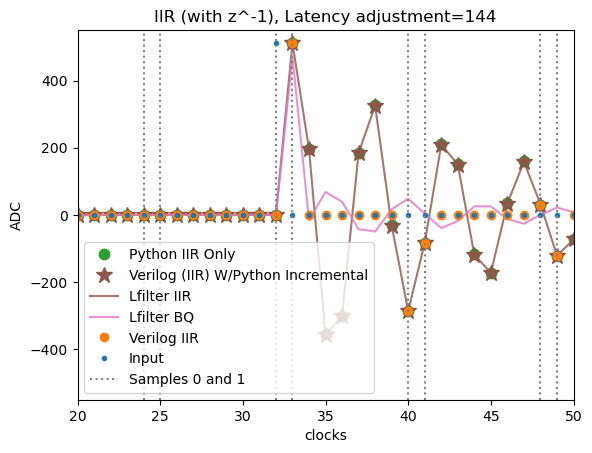

[ 0.92138672 -0.38317871  0.92138672]
[ 1.         -0.38317871  0.84277344]


In [31]:
clocks = range(len(pulse_samps))
clocks = range(np.min([len(pulse_samps),len(verilog_data)]))
# plt.plot(clocks, IIR_data[:len(clocks)], linestyle="None", marker="o", label="Verilog IIR", color="C1")
# plt.plot(clocks, python_data_trimmed[:len(clocks)], linestyle="None", marker=".", markersize=15, label="Python IIR first", color="C2")
# plt.plot(clocks, python_data_zero_first_trimmed[:len(clocks)], linestyle="None", marker="+", markersize=10, label="Python FIR first", color="C3")
plt.plot(clocks, python_IIR_trimmed[:len(clocks)], linestyle="None", marker=".", markersize=15, label="Python IIR Only", color="C2")
# plt.plot(clocks[:clipped_length], incremental_data, linestyle="None", marker="*", markersize=8, label="Verilog W/Python Incremental and Zero", color="C4")
plt.plot(clocks[:clipped_length], incremental_before, linestyle="None", marker="*", markersize=12, label="Verilog (IIR) W/Python Incremental", color="C5")
plt.plot(clocks, lfilter_data_IIR_trimmed[:len(clocks)], linestyle="-", label="Lfilter IIR", alpha=0.8, color="C5")
plt.plot(clocks, lfilter_data_trimmed[:len(clocks)], linestyle="-", label="Lfilter BQ", alpha=0.8, color="C6")
plt.plot(clocks, IIR_data[:len(clocks)], linestyle="None", marker="o", label="Verilog IIR", color="C1")
plt.plot(clocks, pulse_samps[:len(clocks)], linestyle="None", marker=".", label="Input", color="C0")
for i in range(40):
    plt.axvline(x=8*i, linestyle=":", color="grey")
    plt.axvline(x=8*i+1, linestyle=":", color="grey")

plt.axvline(x=8*41, linestyle=":", color="grey", label="Samples 0 and 1")
plt.xlim(20,50)
plt.ylim(-550,550)
# plt.xlim(100,150)
# plt.ylim(-5,5)
plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
print("MAY BE DOUBLE COUNTING THE NUMERATOR, SUBTRACTED FROM ITERATIVE, SINCE B=[0,1,0] IS AREADY THERE")
plt.title("IIR (with z^-1), Latency adjustment=%s"%verilog_nominal_latency)
plt.xlabel("clocks")
plt.ylabel("ADC")
plt.savefig("debug.png",dpi=500)
plt.show()
print(b_fixed_point_signed/(2**14))
print(a_fixed_point_signed/(2**14))


MAY BE DOUBLE COUNTING THE NUMERATOR, SUBTRACTED FROM ITERATIVE, SINCE B=[0,1,0] IS AREADY THERE


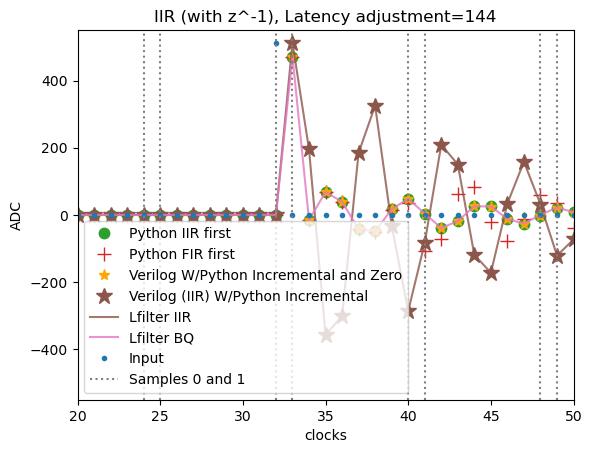

[ 0.92138672 -0.38317871  0.92138672]
[ 1.         -0.38317871  0.84277344]


In [32]:
clocks = range(len(pulse_samps))
clocks = range(np.min([len(pulse_samps),len(verilog_data)]))
# plt.plot(clocks, IIR_data[:len(clocks)], linestyle="None", marker="o", label="Verilog IIR", color="C1")
plt.plot(clocks, python_data_trimmed[:len(clocks)], linestyle="None", marker=".", markersize=15, label="Python IIR first", color="C2")
plt.plot(clocks, python_data_zero_first_trimmed[:len(clocks)], linestyle="None", marker="+", markersize=10, label="Python FIR first", color="C3")
# plt.plot(clocks, python_IIR_trimmed[:len(clocks)], linestyle="None", marker=".", markersize=15, label="Python IIR Only", color="C2")
plt.plot(clocks[:clipped_length], incremental_data, linestyle="None", marker="*", markersize=8, label="Verilog W/Python Incremental and Zero", color="orange")#"C4")
plt.plot(clocks[:clipped_length], incremental_before, linestyle="None", marker="*", markersize=12, label="Verilog (IIR) W/Python Incremental", color="C5")
plt.plot(clocks, lfilter_data_IIR_trimmed[:len(clocks)], linestyle="-", label="Lfilter IIR", alpha=0.8, color="C5")
plt.plot(clocks, lfilter_data_trimmed[:len(clocks)], linestyle="-", label="Lfilter BQ", alpha=0.8, color="C6")
# plt.plot(clocks, IIR_data[:len(clocks)], linestyle="None", marker="o", label="Verilog IIR", color="C1")
plt.plot(clocks, pulse_samps[:len(clocks)], linestyle="None", marker=".", label="Input", color="C0")
for i in range(40):
    plt.axvline(x=8*i, linestyle=":", color="grey")
    plt.axvline(x=8*i+1, linestyle=":", color="grey")

plt.axvline(x=8*41, linestyle=":", color="grey", label="Samples 0 and 1")
plt.xlim(20,50)
plt.ylim(-550,550)
# plt.xlim(100,150)
# plt.ylim(-5,5)
plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
print("MAY BE DOUBLE COUNTING THE NUMERATOR, SUBTRACTED FROM ITERATIVE, SINCE B=[0,1,0] IS AREADY THERE")
plt.title("IIR (with z^-1), Latency adjustment=%s"%verilog_nominal_latency)
plt.xlabel("clocks")
plt.ylabel("ADC")
plt.savefig("debug.png",dpi=500)
plt.show()
print(b_fixed_point_signed/(2**14))
print(a_fixed_point_signed/(2**14))


#### Zero First in Verilog

In [33]:
TRIALS = 1
NOTCH = 650
Q_FACTOR = 8
DEBUG = 0
verilog_nominal_latency = 144 + 0 # The +1 is for the latency added by the b=[0,1,0] numerator

b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)
print("b = %s"%b)

verilog_data = []
with open("001_files/outputs/verilog/pulse_output_height_512_notch_650MHz_8Q.dat", "r") as in_file:
    data = []
    for line in in_file:
        data.append(convert_from_fixed_point(int(int(line)), 12, 0))
        #L NEED TO FIND LATENCY, AND THEN APPLY FILTER NORMALLY FOR SAMPLES 2-7
    verilog_data = np.array(data[verilog_nominal_latency:],dtype=np.int64)
print(len(data))
pulse_run = import_data("001_files/inputs/pulse_input_height_512_clipped.dat")
pulse_original_samps = pulse_run.copy()
pulse_samps = pulse_run[:-verilog_nominal_latency].copy()
print(len(pulse_run))

coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

python_data_IIR = iir_biquad_run_fixed_point(pulse_original_samps.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

python_data_FIR = np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],pulse_original_samps.copy())),dtype=np.int64)
python_data_zero_first = np.right_shift(iir_biquad_run_fixed_point(python_data_FIR.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) ,14)

python_IIR_trimmed = python_data_IIR[:-verilog_nominal_latency].copy()
python_data_trimmed = python_data[:-verilog_nominal_latency].copy()
python_data_zero_first_trimmed = python_data_zero_first[:-verilog_nominal_latency].copy()

lfilter_data = lfilter(b_fixed_point_signed/(2**14),a, pulse_original_samps.copy()) 
# lfilter_data = lfilter([1,0,0],a, pulse_original_samps.copy()) 
lfilter_data_trimmed = lfilter_data[:-verilog_nominal_latency].copy()

########################
########################
########################
FIR_OFFSET=1
USE_FIR = False
clipped_length = int(len(verilog_data)/8)*8
incremental_data = verilog_data.copy()[:clipped_length]
CLA_data = verilog_data.copy()[:clipped_length]
# FINISH FIR in first two
for clock in range(int(len(verilog_data)/8)):
    for i in range(0,2):
        idx = clock*8+i
        if USE_FIR: # This is being applied to existing outputs
            incremental_data[idx] = np.right_shift((b_fixed_point_signed[0]) * CLA_data[idx],14)
            incremental_data[idx] += np.right_shift((b_fixed_point_signed[1]) * CLA_data[idx-1],14)
            incremental_data[idx] += np.right_shift((b_fixed_point_signed[2]) * CLA_data[idx-2],14)
# Complete last 6
    for i in range(2,8):
        idx = clock*8+i
        if USE_FIR:
            incremental_data[idx] += b_fixed_point_signed[0] * pulse_samps[idx-FIR_OFFSET]
            incremental_data[idx] += b_fixed_point_signed[1] * pulse_samps[idx-1-FIR_OFFSET]
            incremental_data[idx] += b_fixed_point_signed[2] * pulse_samps[idx-2-FIR_OFFSET]
        incremental_data[idx] -= a_fixed_point_signed[1] * incremental_data[idx-1]
        incremental_data[idx] -= a_fixed_point_signed[2] * incremental_data[idx-2]
        incremental_data[idx] = np.right_shift(incremental_data[idx],14)


# # FINISH IIR
# for clock in range(int(len(verilog_data)/8)):
#     for i in range(2,8):
#         idx = clock*8+i
#         incremental_data[idx] += 16384 * pulse_samps[idx-FIR_OFFSET]
#         incremental_data[idx] -= a_fixed_point_signed[1] * incremental_data[idx-1]
#         incremental_data[idx] -= a_fixed_point_signed[2] * incremental_data[idx-2]
#         incremental_data[idx] = np.right_shift(incremental_data[idx],14)
# # USE FIR
# incremental_before = incremental_data.copy()
# for clock in range(int(len(verilog_data)/8)):
#     for i in range(0,8):
#         idx = clock*8+i
#         if USE_FIR: # This is being applied to existing outputs
#             incremental_data[idx] = int((b_fixed_point_signed[0]/(2**14)) * incremental_before[idx])
#             incremental_data[idx] += int((b_fixed_point_signed[1]/(2**14)) * incremental_before[idx-1])
#             incremental_data[idx] += int((b_fixed_point_signed[2]/(2**14)) * incremental_before[idx-2])

b = [ 0.9214121 -0.3831447  0.9214121]
80056
80064


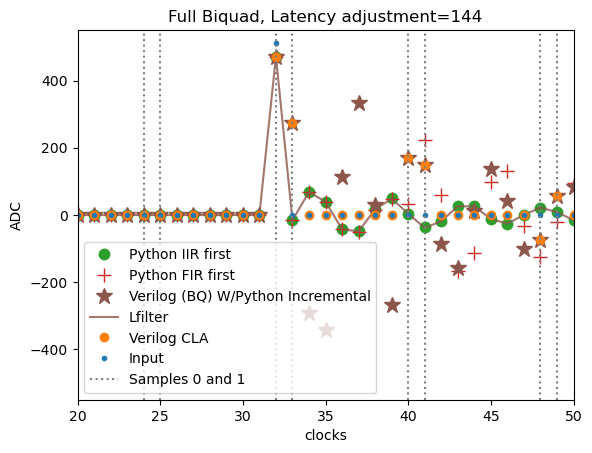

[ 0.92138672 -0.38317871  0.92138672]
[ 1.         -0.38317871  0.84277344]


In [34]:
clocks = range(len(pulse_samps))
clocks = range(np.min([len(pulse_samps),len(verilog_data)]))
# plt.plot(clocks, IIR_data[:len(clocks)], linestyle="None", marker="o", label="Verilog IIR", color="C1")
plt.plot(clocks, python_data_trimmed[:len(clocks)], linestyle="None", marker=".", markersize=15, label="Python IIR first", color="C2")
plt.plot(clocks, python_data_zero_first_trimmed[:len(clocks)], linestyle="None", marker="+", markersize=10, label="Python FIR first", color="C3")
# plt.plot(clocks, python_IIR_trimmed[:len(clocks)], linestyle="None", marker=".", markersize=15, label="Python IIR Only", color="C2")
# plt.plot(clocks[:clipped_length], incremental_data, linestyle="None", marker="*", markersize=8, label="Verilog W/Python Incremental and Zero", color="C4")
plt.plot(clocks[:clipped_length], incremental_data, linestyle="None", marker="*", markersize=12, label="Verilog (BQ) W/Python Incremental", color="C5")
plt.plot(clocks, lfilter_data_trimmed[:len(clocks)], linestyle="-", label="Lfilter", alpha=0.8, color="C5")
plt.plot(clocks, CLA_data[:len(clocks)], linestyle="None", marker="o", label="Verilog CLA", color="C1")
plt.plot(clocks, pulse_samps[:len(clocks)], linestyle="None", marker=".", label="Input", color="C0")
for i in range(40):
    plt.axvline(x=8*i, linestyle=":", color="grey")
    plt.axvline(x=8*i+1, linestyle=":", color="grey")

plt.axvline(x=8*41, linestyle=":", color="grey", label="Samples 0 and 1")
plt.xlim(20,50)
plt.ylim(-550,550)
# plt.xlim(100,150)
# plt.ylim(-5,5)
plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
plt.title("Full Biquad, Latency adjustment=%s"%verilog_nominal_latency)
plt.xlabel("clocks")
plt.ylabel("ADC")
plt.savefig("debug.png",dpi=500)
plt.show()
print(b_fixed_point_signed/(2**14))
print(a_fixed_point_signed/(2**14))


### Testing on Gaussians

In [35]:
DEBUG=False
TRIALS = 19
NOTCH = 650
Q_FACTOR = 8
verilog_nominal_latency = 144 + 0 # The +1 is for the latency added by the b=[0,1,0] numerator

b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)

with open("001_files/outputs/verilog/no_zero_output_gauss_400_trial_%s_notch_%s_MHz_%s.txt"%(TRIALS-1, NOTCH, Q_FACTOR), "r") as in_file:
    data = []
    for line in in_file:
        data.append(convert_from_fixed_point(int(int(line)), 12, 0))
        #L NEED TO FIND LATENCY, AND THEN APPLY FILTER NORMALLY FOR SAMPLES 2-7
    verilog_data = np.array(data[verilog_nominal_latency:],dtype=np.int64)
    clipped_length = int(len(verilog_data)/8)*8
gauss_samps_array = np.zeros((TRIALS, clipped_length))
output_samps_array = np.zeros((TRIALS, clipped_length))
python_zero_after_samps_array = np.zeros((TRIALS, clipped_length))

for trial_idx in range(TRIALS):
    verilog_data = []
    with open("001_files/outputs/verilog/no_zero_output_gauss_400_trial_%s_notch_%s_MHz_%s.txt"%(trial_idx, NOTCH, Q_FACTOR), "r") as in_file:
        data = []
        for line in in_file:
            data.append(convert_from_fixed_point(int(int(line)), 12, 0))
            #L NEED TO FIND LATENCY, AND THEN APPLY FILTER NORMALLY FOR SAMPLES 2-7
        verilog_data = np.array(data[verilog_nominal_latency:],dtype=np.int64)
    # print(len(data))
    #gauss_input_400_sigma_hanning_clipped_0.dat
    gauss_run = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%s.dat"%trial_idx)
    gauss_original_samps = gauss_run.copy()
    gauss_delayed_samps = lfilter([0,1,0], [1], np.array(gauss_run.copy(), dtype=float))
    gauss_samps = gauss_run[:clipped_length].copy()
    # print(len(gauss_run))
    
    coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))
    
    python_data_IIR = iir_biquad_run_fixed_point(gauss_delayed_samps.copy(), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
    python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)
    
    python_data_FIR = np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],gauss_delayed_samps.copy())),dtype=np.int64)
    python_data_zero_first = np.right_shift(iir_biquad_run_fixed_point(python_data_FIR.copy(), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) ,14)
    
    python_IIR_trimmed = python_data_IIR[:-verilog_nominal_latency].copy()
    python_data_trimmed = python_data[:-verilog_nominal_latency].copy()
    python_data_zero_first_trimmed = python_data_zero_first[:-verilog_nominal_latency].copy()
    lfilter_data_IIR = lfilter([1,0,0],a, gauss_delayed_samps.copy()) 
    lfilter_data_IIR_trimmed = lfilter_data_IIR[:-verilog_nominal_latency].copy()
    lfilter_data = lfilter(b,a, gauss_delayed_samps.copy()) 
    lfilter_data_trimmed = lfilter_data[:-verilog_nominal_latency].copy()
    lfilter_data_trimmed = lfilter_data[:-verilog_nominal_latency].copy()
    
    
    FIR_OFFSET=1
    USE_FIR = True
    # commented and moved before loop
    # clipped_length = int(len(verilog_data)/8)*8
    incremental_data = verilog_data.copy()[:clipped_length]
    IIR_data = verilog_data.copy()[:clipped_length]
    # FINISH IIR
    # for clock in range(int(len(verilog_data)/8)):
    #     for i in range(0,2):
    #         idx = clock*8+i
    #         if USE_FIR: # This is being applied to existing outputs
    #             incremental_data[idx] = np.right_shift((b_fixed_point_signed[0]) * IIR_data[idx],14)
    #             incremental_data[idx] += np.right_shift((b_fixed_point_signed[1]) * IIR_data[idx-1],14)
    #             incremental_data[idx] += np.right_shift((b_fixed_point_signed[2]) * IIR_data[idx-2],14)
    # # RUN FIR
    #     for i in range(2,8):
    #         idx = clock*8+i
    #         if USE_FIR:
    #             incremental_data[idx] += b_fixed_point_signed[0] * gauss_samps[idx-FIR_OFFSET]
    #             incremental_data[idx] += b_fixed_point_signed[1] * gauss_samps[idx-1-FIR_OFFSET]
    #             incremental_data[idx] += b_fixed_point_signed[2] * gauss_samps[idx-2-FIR_OFFSET]
    #         incremental_data[idx] -= a_fixed_point_signed[1] * incremental_data[idx-1]
    #         incremental_data[idx] -= a_fixed_point_signed[2] * incremental_data[idx-2]
    #         incremental_data[idx] = np.right_shift(incremental_data[idx],14)
    
    
    # FINISH IIR
    for clock in range(int(len(verilog_data)/8)):
        for i in range(2,8):
            idx = clock*8+i
            incremental_data[idx] += 16384 * gauss_samps[idx-FIR_OFFSET]
            incremental_data[idx] -= a_fixed_point_signed[1] * incremental_data[idx-1]
            incremental_data[idx] -= a_fixed_point_signed[2] * incremental_data[idx-2]
            incremental_data[idx] = np.right_shift(incremental_data[idx],14)
    # USE FIR
    incremental_before = incremental_data.copy()
    for clock in range(int(len(verilog_data)/8)):
        for i in range(0,8):
            idx = clock*8+i
            if USE_FIR: # This is being applied to existing outputs
                incremental_data[idx] = int((b_fixed_point_signed[0]/(2**14)) * incremental_before[idx])
                incremental_data[idx] += int((b_fixed_point_signed[1]/(2**14)) * incremental_before[idx-1])
                incremental_data[idx] += int((b_fixed_point_signed[2]/(2**14)) * incremental_before[idx-2])
    clocks = range(len(gauss_samps))
    clocks = range(np.min([len(gauss_samps),len(verilog_data)]))
    gauss_samps_array[trial_idx] = gauss_samps[:len(clocks)]
    output_samps_array[trial_idx] = incremental_data[:len(clocks)]
    python_zero_after_samps_array[trial_idx] = python_data_trimmed[:len(clocks)]

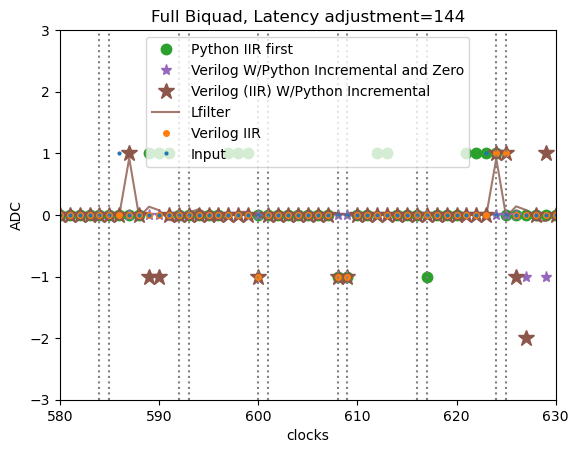

[ 0.92138672 -0.38317871  0.92138672]
[ 1.         -0.38317871  0.84277344]


In [37]:
# plt.plot(clocks, IIR_data[:len(clocks)], linestyle="None", marker="o", label="Verilog IIR", color="C1")
plt.plot(clocks, python_data_trimmed[:len(clocks)], linestyle="None", marker=".", markersize=15, label="Python IIR first", color="C2")
# plt.plot(clocks, python_data_zero_first_trimmed[:len(clocks)], linestyle="None", marker="+", markersize=10, label="Python FIR first", color="C3")
# plt.plot(clocks, python_IIR_trimmed[:len(clocks)], linestyle="None", marker=".", markersize=15, label="Python IIR Only", color="C2")
plt.plot(clocks[:clipped_length], incremental_data, linestyle="None", marker="*", markersize=8, label="Verilog W/Python Incremental and Zero", color="C4")
plt.plot(clocks[:clipped_length], incremental_before, linestyle="None", marker="*", markersize=12, label="Verilog (IIR) W/Python Incremental", color="C5")
plt.plot(clocks, lfilter_data_trimmed[:len(clocks)], linestyle="-", label="Lfilter", alpha=0.8, color="C5")
plt.plot(clocks, IIR_data[:len(clocks)], linestyle="None", marker=".", markersize=8, label="Verilog IIR", color="C1")
plt.plot(clocks, gauss_samps[:len(clocks)], linestyle="None", marker=".", markersize=4, label="Input", color="C0")
for i in range(int(12000/8)):
    plt.axvline(x=8*i, linestyle=":", color="grey")
    plt.axvline(x=8*i+1, linestyle=":", color="grey")

# plt.axvline(x=8*41, linestyle=":", color="grey", label="Samples 0 and 1")
# plt.xlim(10000,10070)
offset=580
plt.xlim(0+offset,50+offset)
plt.ylim(-3,3)
# plt.ylim(-5,5)
# plt.ylim(-1000,1000)
plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
plt.title("Full Biquad, Latency adjustment=%s"%verilog_nominal_latency)
plt.xlabel("clocks")
plt.ylabel("ADC")
plt.savefig("debug.png",dpi=500)
plt.show()
print(b_fixed_point_signed/(2**14))
print(a_fixed_point_signed/(2**14))


MAY BE DOUBLE COUNTING THE NUMERATOR, SUBTRACTED FROM ITERATIVE, SINCE B=[0,1,0] IS AREADY THERE


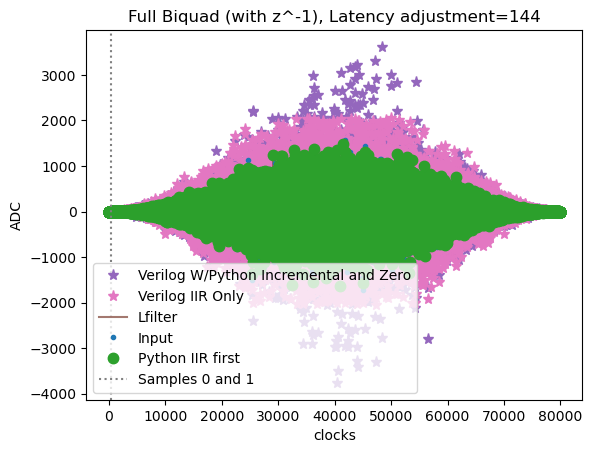

[ 0.92138672 -0.38317871  0.92138672]
[ 1.         -0.38317871  0.84277344]
gauss 586
inc 627
IIR 600


In [39]:
# clocks = range(len(gauss_samps))
# clocks = range(np.min([len(gauss_samps),len(verilog_data)]))
# plt.plot(clocks, verilog_data[:len(clocks)], linestyle="None", marker="o", label="Verilog IIR", color="C1")
# plt.plot(clocks, python_data_zero_first_trimmed[:len(clocks)], linestyle="None", marker="+", markersize=10, label="Python FIR first", color="C3")
plt.plot(clocks[:clipped_length], incremental_data, linestyle="None", marker="*", markersize=8, label="Verilog W/Python Incremental and Zero", color="C4")
plt.plot(clocks[:clipped_length], IIR_data, linestyle="None", marker="*", markersize=8, label="Verilog IIR Only", color="C6")
plt.plot(clocks, lfilter_data_trimmed[:len(clocks)], linestyle="-", label="Lfilter", alpha=0.8, color="C5")
plt.plot(clocks, gauss_samps[:len(clocks)], linestyle="None", marker=".", label="Input", color="C0")
plt.plot(clocks, python_data_trimmed[:len(clocks)], linestyle="None", marker=".", markersize=15, label="Python IIR first", color="C2")
# for i in range(40):
#     plt.axvline(x=8*i, linestyle=":", color="grey")
#     plt.axvline(x=8*i+1, linestyle=":", color="grey")

plt.axvline(x=8*41, linestyle=":", color="grey", label="Samples 0 and 1")
# plt.xlim(550,720)
# plt.xlim(0,20)
# plt.ylim(-10,10)
# plt.ylim(-1000,1000)
plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
print("MAY BE DOUBLE COUNTING THE NUMERATOR, SUBTRACTED FROM ITERATIVE, SINCE B=[0,1,0] IS AREADY THERE")
plt.title("Full Biquad (with z^-1), Latency adjustment=%s"%verilog_nominal_latency)
plt.xlabel("clocks")
plt.ylabel("ADC")
plt.savefig("debug.png",dpi=500)
plt.show()
print(b_fixed_point_signed/(2**14))
print(a_fixed_point_signed/(2**14))
for i in range(len(gauss_samps)):
    if (gauss_samps[i] != 0):
        print("gauss %s"%i)
        break
for i in range(len(incremental_data)):
    if (incremental_data[i] != 0):
        print("inc %s"%i)
        break
for i in range(len(IIR_data)):
    if (IIR_data[i] != 0):
        print("IIR %s"%i)
        break

# MAYBE THE RIGHT THING TO DO IS CHECK THE IIR DELAY ON THE PULSES

79912
[3.83396424e+09 5.69471777e+09 4.28677625e+09 ... 3.20332493e+09
 4.28677625e+09 5.69471777e+09]
[ 0.          0.0375413   0.07508259 ... -0.11262389 -0.07508259
 -0.0375413 ]
[ 5.63119431  5.66873561  5.7062769  ... -5.7438182  -5.7062769
 -5.66873561]


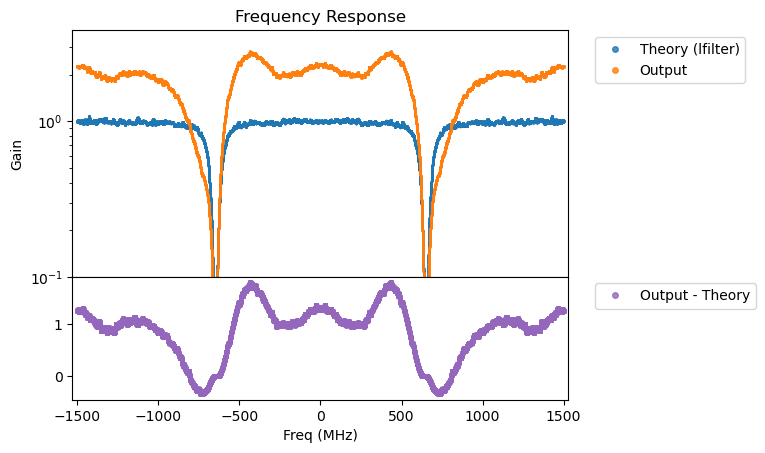

In [24]:
print(len(clocks))
frequency_response_manual(clocks, gauss_samps_array, output_samps_array, smooth=301, savename="001_files/images/00_Verilog_test", lfilter_coeffs=[b, a])

79912
[3.83396424e+09 5.69471777e+09 4.28677625e+09 ... 3.20332493e+09
 4.28677625e+09 5.69471777e+09]
[ 0.          0.0375413   0.07508259 ... -0.11262389 -0.07508259
 -0.0375413 ]
[ 5.63119431  5.66873561  5.7062769  ... -5.7438182  -5.7062769
 -5.66873561]


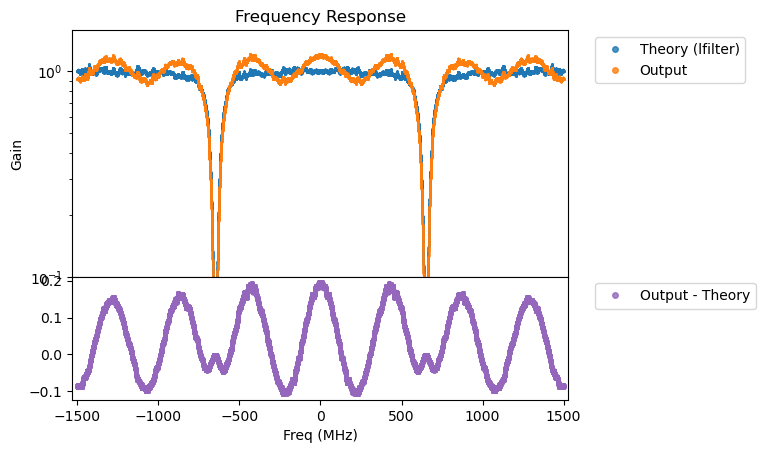

In [25]:
print(len(clocks))
frequency_response_manual(clocks, gauss_samps_array,  python_zero_after_samps_array, smooth=301, savename="001_files/images/00_Verilog_test", lfilter_coeffs=[b, a])

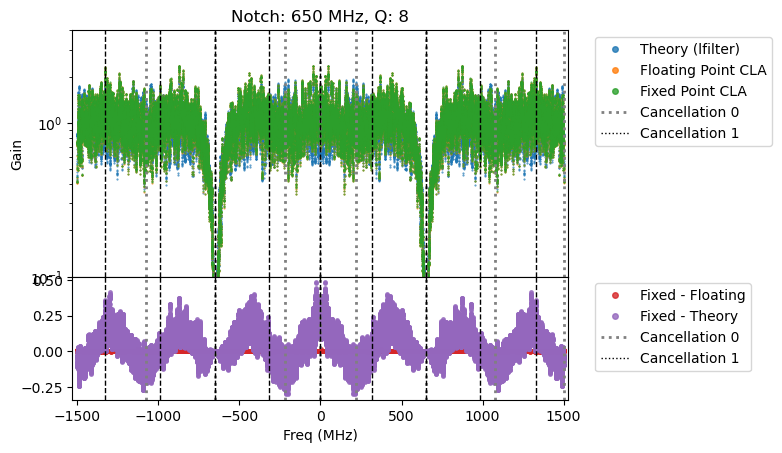

<Figure size 640x480 with 0 Axes>

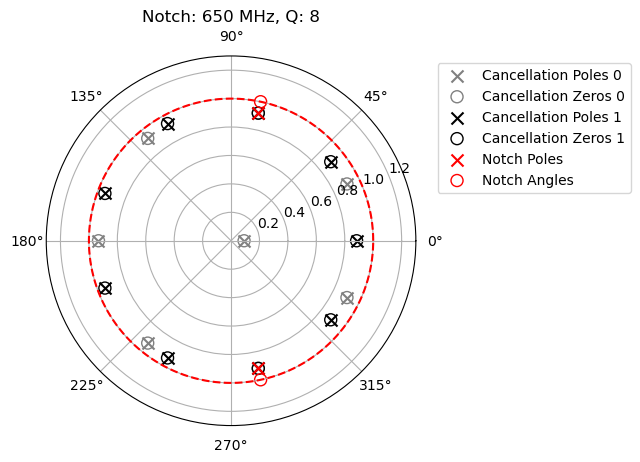

In [44]:
gaussian_probe_frequency_response(trials=TRIALS, notch=NOTCH, q_factor=Q_FACTOR, smooth=35, savename="001_files/images/debug")

# Cancelling Poles and Zeros

Note that this is not necessarily representative of PUEO's biquad

[ 1.28386392+5.82404842e-01j  1.28386392-5.82404842e-01j
  0.39512111+1.31704067e+00j  0.39512111-1.31704067e+00j
 -0.69733994+1.08652926e+00j -0.69733994-1.08652926e+00j
 -0.9816451 +8.56182152e-09j -0.9816451 -8.56182152e-09j]
[0.99650764 0.99650764 0.9820084  0.9820084  0.95161641 0.95161641
 0.90698124 0.90698124 0.87851702]


<Figure size 640x480 with 0 Axes>

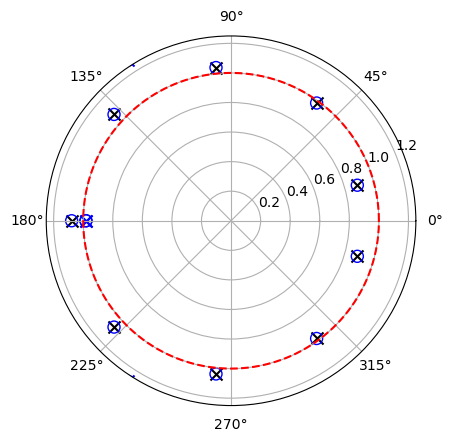

In [62]:
TRIALS = 100
NOTCH = 450#520
Q_FACTOR = 30
SAMPLE_FREQ = 3000
DEBUG=0

b, a = signal.iirnotch(NOTCH,Q_FACTOR, SAMPLE_FREQ)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

characteristic_poly0 = [1,0,0,0,0,0,0,0,-1*eval_chebyu(8,np.cos(pangle))*(pmag**8),eval_chebyu(7,np.cos(pangle))*(pmag**9)]
roots = np.roots(characteristic_poly0)
print(roots0)
cancel_mags0 = np.abs(roots0)
cancel_angles0 = np.angle(roots0)

characteristic_poly1 = [1,0,0,0,0,0,0,0,-1*eval_chebyu(8,np.cos(pangle))*(pmag**8),eval_chebyu(7,np.cos(pangle))*(pmag**9)] # M=8
roots1 = np.roots(characteristic_poly1)
cancel_mags1 = np.abs(roots1)
cancel_angles1 = np.angle(roots1)

plt.clf()
fig = plt.figure(num='Biquad CLA Cancels',figsize=(10,4.8))
ax=fig.add_subplot(1,10,(1,10),projection='polar')
ax.set_rlim(0,1.25)

# real_cancels = np.real(roots)
# im_cancels = np.imag(roots)

print(cancel_mags)
poles = ax.scatter(cancel_angles0,cancel_mags0,c='blue',marker="x", s=75)
zeros = ax.scatter(cancel_angles0,cancel_mags0, marker="o", s=75,facecolors='none', edgecolors='blue')
poles = ax.scatter(cancel_angles1,cancel_mags1,c='black',marker="x", s=75)
zeros = ax.scatter(cancel_angles1,cancel_mags1, marker="o", s=75,facecolors='none', edgecolors='blue')
unit_circle = ax.plot(np.linspace(0,2*np.pi,1000), np.ones(1000), color="red", linestyle="--")
plt.show()


# Notch Stable Phase Space

In [70]:
SAMPLE_FREQ = 3000
x, y = np.meshgrid(np.arange(1,1490,5),np.linspace(1,20,100))
z = np.zeros((len(x),len(x[0])))
print(x.shape[0])
print(x.shape[1])
print(y.shape[0])
print(y.shape[1])
print(x)
print(y)
for q_factor_idx in range(x.shape[0]):#100
    # print(x[0][notch_idx])
    for notch_idx in range(x.shape[1]):#60
        print("Notch: %s, Q: %s"%(x[q_factor_idx][notch_idx], y[q_factor_idx][notch_idx]))
        b, a = signal.iirnotch(x[q_factor_idx][notch_idx],y[q_factor_idx][notch_idx], SAMPLE_FREQ)
        # b, a = signal.iirnotch(520,30, SAMPLE_FREQ)
        pole = signal.tf2zpk(b,a)[1][0]
        zero = signal.tf2zpk(b,a)[0][0]
        pmag=np.abs(pole)
        pangle=np.angle(pole)
        zmag=np.abs(zero)
        zangle=np.angle(zero)


        characteristic_poly0 = [1,0,0,0,0,0,0,-1*eval_chebyu(7,np.cos(pangle))*(pmag**7),eval_chebyu(6,np.cos(pangle))*(pmag**8)] # M=7
        roots0 = np.roots(characteristic_poly0)
        cancel_mags0 = np.abs(roots0)
        cancel_angles0 = np.angle(roots0)
            
        characteristic_poly1 = [1,0,0,0,0,0,0,0,-1*eval_chebyu(8,np.cos(pangle))*(pmag**8),eval_chebyu(7,np.cos(pangle))*(pmag**9)] # M=8
        roots1 = np.roots(characteristic_poly1)
        cancel_mags1 = np.abs(roots1)
        cancel_angles1 = np.angle(roots1)

        
        characteristic_poly0 = [1,0,0,0,0,0,0,-1*eval_chebyu(7,np.cos(pangle))*(pmag**7),eval_chebyu(6,np.cos(pangle))*(pmag**8)] # M=7
        roots0 = np.roots(characteristic_poly0)
        cancel_mags0 = np.abs(roots0)
        cancel_angles0 = np.angle(roots0)
        characteristic_poly1 = [1,0,0,0,0,0,0,0,-1*eval_chebyu(8,np.cos(pangle))*(pmag**8),eval_chebyu(7,np.cos(pangle))*(pmag**9)] # M=8
        roots1 = np.roots(characteristic_poly1)
        cancel_mags1 = np.abs(roots1)
        cancel_angles1 = np.angle(roots1)
        # print(np.max(cancel_mags0))
        if (np.max(cancel_mags0)<1 and np.max(cancel_mags1)<1):
            # print("found one")
            z[q_factor_idx][notch_idx] = 1

        
        # plt.clf()
        # fig = plt.figure(num='Biquad CLA Cancels',figsize=(10,4.8))
        # ax=fig.add_subplot(1,10,(1,10),projection='polar')
        # ax.set_rlim(0,1.25)
        # poles = ax.scatter(cancel_angles0,cancel_mags0,c='blue',marker="x", s=75)
        # zeros = ax.scatter(cancel_angles1,cancel_mags1, marker="o", s=75,facecolors='none', edgecolors='blue')
        # unit_circle = ax.plot(np.linspace(0,2*np.pi,1000), np.ones(1000), color="red", linestyle="--")
        # plt.show()
        # break
       

100
298
100
298
[[   1    6   11 ... 1476 1481 1486]
 [   1    6   11 ... 1476 1481 1486]
 [   1    6   11 ... 1476 1481 1486]
 ...
 [   1    6   11 ... 1476 1481 1486]
 [   1    6   11 ... 1476 1481 1486]
 [   1    6   11 ... 1476 1481 1486]]
[[ 1.          1.          1.         ...  1.          1.
   1.        ]
 [ 1.19191919  1.19191919  1.19191919 ...  1.19191919  1.19191919
   1.19191919]
 [ 1.38383838  1.38383838  1.38383838 ...  1.38383838  1.38383838
   1.38383838]
 ...
 [19.61616162 19.61616162 19.61616162 ... 19.61616162 19.61616162
  19.61616162]
 [19.80808081 19.80808081 19.80808081 ... 19.80808081 19.80808081
  19.80808081]
 [20.         20.         20.         ... 20.         20.
  20.        ]]
Notch: 1, Q: 1.0
Notch: 6, Q: 1.0
Notch: 11, Q: 1.0
Notch: 16, Q: 1.0
Notch: 21, Q: 1.0
Notch: 26, Q: 1.0
Notch: 31, Q: 1.0
Notch: 36, Q: 1.0
Notch: 41, Q: 1.0
Notch: 46, Q: 1.0
Notch: 51, Q: 1.0
Notch: 56, Q: 1.0
Notch: 61, Q: 1.0
Notch: 66, Q: 1.0
Notch: 71, Q: 1.0
Notch: 76, Q

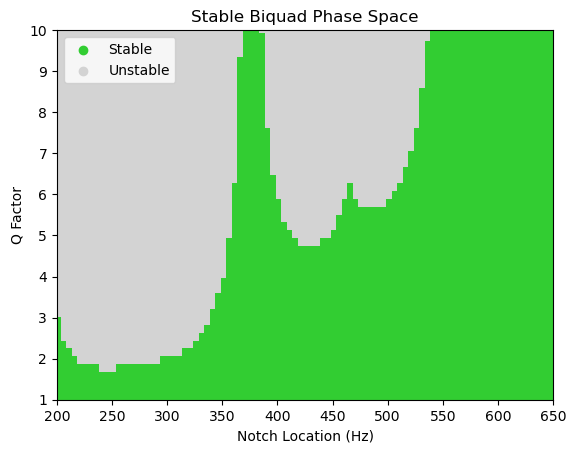

In [96]:
cMap = matplotlib.colors.ListedColormap(['lightgrey','limegreen'])
h = plt.pcolormesh(x, y, z, cmap=cMap)
# plt.axis("scaled")
# plt.colorbar()
plt.scatter([],[],color="limegreen", label="Stable")
plt.scatter([],[],color="lightgrey", label="Unstable")
plt.title("Stable Biquad Phase Space")
plt.xlabel("Notch Location (Hz)")
plt.ylabel("Q Factor")
plt.legend(loc=2)
plt.xlim(200, 650)
plt.ylim(1, 10)
plt.savefig("001_files/images/notch_phase_space.png")
plt.show()

# Unfortunate Scratch

In [ ]:
fft_input_result = {}
fft_patrick_result = {}
fft_lfilter_result = {}
fft_python_result = {}

In [ ]:
TRIALS = 1000
ONLY_L = True
NOTCH_A = 375
Q_A =  # fq/bw

NOTCH_B = 460
Q_B = NOTCH_B / 50

# Get the parameters of the notch
b, a = signal.iirnotch(NOTCH_A, Q_A, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

# Get the coefficients for the quantized biquad
coeffs = iir_biquad_coeffs(pmag, pangle)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed = np.zeros(len(b))
a_fixed_point_signed = np.zeros(len(a))

## Usual Fixed Point
# For transfer function numerator
for i in range(len(b)):
    b_fixed_point_signed[i] = np.floor(b[i] * (2**14))
b_fixed_point_signed = np.array(b_fixed_point_signed, dtype=np.int64)
# Just in case we want to compare these later
# For transfer function denominator, after look-ahead
for i in range(len(a)):
    a_fixed_point_signed[i] = np.floor(a[i] * (2**14))
a_fixed_point_signed = np.array(a_fixed_point_signed, dtype=np.int64)
#  For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed[i] = np.floor(coeffs[i] * (2**14))

coeffs_fixed_point_signed = np.array(coeffs_fixed_point_signed, dtype=np.int64)

# Import the Gaussian input data once to get the lengths
data_len = len(import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%0))
fft_input_results = np.zeros((TRIALS, data_len))     
fft_patrick_results = np.zeros((TRIALS, data_len))     
fft_python_results = np.zeros((TRIALS, data_len))   
fft_lfilter_results = np.zeros((TRIALS, data_len))

# Run the trials on the data
for i in range(TRIALS):
    # Import the trial inputs
    gauss_samps = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%i)

    lfilter_data = lfilter(b,a,gauss_samps.copy())
    # Run the filters on the trials
    if not ONLY_L:
        patrick_data = lfilter(b,[1],patrick_biquad(gauss_samps.copy(), 8, pmag, pangle, ics = None))
    
    
        python_data_IIR = iir_biquad_run_fixed_point(gauss_samps.copy(), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
        python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)
    
        # # The "a"s being used are not quantized, they are processed as floating point
        # python_data_iir = iir_biquad_run_fixed_point(gauss_samps.copy(), coeffs_fixed_point_signed, 
        #                                          decimate=False, a1=a[1], a2=a[2],debug=0) 
    
        
        # # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
        # python_data = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], python_data_iir)),dtype=np.int64),14)
        
        fft_input_results[i] = np.abs(np.fft.fft(gauss_samps))**2   
        fft_patrick_results[i] = np.abs(np.fft.fft(patrick_data))**2
        fft_python_results[i] = np.abs(np.fft.fft(python_data))**2
    fft_lfilter_results[i] = np.abs(np.fft.fft(lfilter_data))**2
    if(i%10 == 0):
        print(i)


# Get the parameters of the notch
b, a = signal.iirnotch(NOTCH_B, Q_B, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

# Get the coefficients for the quantized biquad
coeffs = iir_biquad_coeffs(pmag, pangle)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed = np.zeros(len(b))
a_fixed_point_signed = np.zeros(len(a))

## Usual Fixed Point
# For transfer function numerator
for i in range(len(b)):
    b_fixed_point_signed[i] = np.floor(b[i] * (2**14))
b_fixed_point_signed = np.array(b_fixed_point_signed, dtype=np.int64)
# Just in case we want to compare these later
# For transfer function denominator, after look-ahead
for i in range(len(a)):
    a_fixed_point_signed[i] = np.floor(a[i] * (2**14))
a_fixed_point_signed = np.array(a_fixed_point_signed, dtype=np.int64)
#  For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed[i] = np.floor(coeffs[i] * (2**14))

coeffs_fixed_point_signed = np.array(coeffs_fixed_point_signed, dtype=np.int64)

# Import the Gaussian input data once to get the lengths
data_len = len(import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%0))
fft_input_results2 = np.zeros((TRIALS, data_len))     
fft_patrick_results2 = np.zeros((TRIALS, data_len))     
fft_python_results2 = np.zeros((TRIALS, data_len))   
fft_lfilter_results2 = np.zeros((TRIALS, data_len))

# Run the trials on the data
for i in range(TRIALS):
    # Import the trial inputs
    # gauss_samps = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%i)

    lfilter_data_2 = lfilter(b,a,lfilter_data.copy())
    # Run the filters on the trials
    if not ONLY_L:

        patrick_data_2 = lfilter(b,[1],patrick_biquad(patrick_data.copy(), 8, pmag, pangle, ics = None))
        python_data_IIR_2 = iir_biquad_run_fixed_point(python_data.copy(), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
        python_data_2 = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR_2.copy())),dtype=np.int64),14)
    
        # # The "a"s being used are not quantized, they are processed as floating point
        # python_data_iir = iir_biquad_run_fixed_point(gauss_samps.copy(), coeffs_fixed_point_signed, 
        #                                          decimate=False, a1=a[1], a2=a[2],debug=0) 
    
        
        # # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
        # python_data = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], python_data_iir)),dtype=np.int64),14)
  
        fft_patrick_results2[i] = np.abs(np.fft.fft(patrick_data_2))**2
        fft_python_results2[i] = np.abs(np.fft.fft(python_data_2))**2
    fft_lfilter_results2[i] = np.abs(np.fft.fft(lfilter_data_2))**2        
    fft_input_results2[i] = np.abs(np.fft.fft(gauss_samps))**2 
    if(i%10 == 0):
        print(i)



fft_lfilter_result[NOTCH_A + 10000*NOTCH_B] = np.mean(fft_lfilter_results2, axis=0)
fft_input_result[NOTCH_A + 10000*NOTCH_B] = np.mean(fft_input_results2, axis=0)
if not ONLY_L:
    fft_patrick_result[NOTCH_A + 10000*NOTCH_B] = np.mean(fft_patrick_results2, axis=0)
    fft_python_result[NOTCH_A + 10000*NOTCH_B] = np.mean(fft_python_results2, axis=0)

In [ ]:
plot_notch_freq_a = 375
plot_notch_freq_b = 460
plot_notch_freq = plot_notch_freq_a + 10000*plot_notch_freq_b
plt.plot(np.fft.fftfreq(len(fft_input_result[plot_notch_freq])),np.abs(fft_input_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="input", markersize=5, alpha=0.9, color="C0")
plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq]), linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
plt.plot(np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq]), linestyle="None",
         marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**8)
plt.title("Gaussian noise in filters")
# plt.xlim(0,0.5)
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()

mean_power = np.mean(fft_input_result[plot_notch_freq])


plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq])/mean_power, linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
plt.plot(np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**-5)
plt.title("Gaussian noise in filters")
plt.xlim(0,0.5)
plt.xlabel("Frequency/(Sampling Frequency)")
plt.ylabel("Gain")
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()

In [ ]:
plot_notch_freq_a = 375
plot_notch_freq_b = 460
plot_notch_freq = plot_notch_freq_a + 10000*plot_notch_freq_b
N=31
print(np.ceil(N/2.0))
# plt.plot(np.fft.fftfreq(len(fft_input_result[plot_notch_freq])),np.abs(fft_input_result[plot_notch_freq]), linestyle="None", 
#          marker=".", label="input", markersize=5, alpha=0.9, color="C0")
# plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq]), linestyle="None", 
#          marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq]))[int(np.floor(N/2.0)):int(-np.floor(N/2.0))],np.convolve(np.abs(fft_lfilter_result[plot_notch_freq]), np.ones(N)/N, mode='valid'), linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
# plt.plot(np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq]), linestyle="None",
#          marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**4)
plt.title("375 and 460 MHz Notches, BW of 50 MHz")
plt.xlim(0,0.5)
plt.savefig("DoubleNotchPlot.png")
plt.show()

print(fft_input_result[plot_notch_freq])
mean_power = np.mean(fft_input_result[plot_notch_freq])


# plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq])/mean_power, linestyle="None", 
#          marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq]))[int(np.floor(N/2.0)):int(-np.floor(N/2.0))],
        np.convolve(np.abs(fft_lfilter_result[plot_notch_freq]), np.ones(N)/N, mode='valid')/mean_power, linestyle="None",
        marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
# plt.plot(np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq])/mean_power, linestyle="None",
#          marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**-5)
plt.title("375 and 460 MHz Notches, BW of 50 MHz")
plt.xlim(0,0.5)
plt.xlabel("Frequency/(Sampling Frequency)")
plt.ylabel("Gain")
plt.savefig("DoubleNotchPlot2.png")
plt.show()

In [ ]:
fft_points = np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq]))[int(np.floor(N/2.0)):int(-np.floor(N/2.0))]

In [ ]:
fft_points[1] - fft_points[0]

In [ ]:
fft_points[10001] - fft_points[10000]